# Deep Q learning


Main Changes:

- QNetwork Class: A neural network with configurable hidden layers (default: 128→128→4 actions) that approximates Q-values
- ReplayBuffer Class: Stores experiences (state, action, reward, next_state, done) for experience replay, which stabilizes training
- DQNAgent Class replaces QLearningAgent with:

  - Two networks: Main Q-network for learning and target network for stable targets
  - Experience replay: Batched learning from past experiences
  - Target network updates: Periodically syncs target network with main network
  - PyTorch optimization: Uses Adam optimizer and MSE loss


Key Hyperparameters:

- Learning rate: 0.001 (lower than Q-learning)
- Batch size: 64
- Buffer size: 10,000 experiences
- Target update frequency: Every 10 training steps



Advantages of DQN:

- Can generalize to unseen states
- More efficient for large state spaces
- Better function approximation
- Uses GPU acceleration if available

Using device: cpu
Training DQN Agent with Changing Target Goals...
Grid Size: 10x10
Number of Goals: 4
Number of Obstacles: 3
Episodes: 500

Episode 100/500 - Avg Reward: -102.36, Avg Steps: 145.79, Epsilon: 0.606, Buffer Size: 10000
Episode 200/500 - Avg Reward: -44.90, Avg Steps: 108.53, Epsilon: 0.367, Buffer Size: 10000
Episode 300/500 - Avg Reward: -40.40, Avg Steps: 104.03, Epsilon: 0.222, Buffer Size: 10000
Episode 400/500 - Avg Reward: -57.57, Avg Steps: 112.11, Epsilon: 0.135, Buffer Size: 10000
Episode 500/500 - Avg Reward: -38.75, Avg Steps: 97.33, Epsilon: 0.082, Buffer Size: 10000

✓ Training Complete!

Testing Trained Agent (ALL Steps Visualization)...
Testing with Target Goal: 0
Agent took 200 steps to reach the goal!
Creating final path visualization...

✓ Saved: gridworld_dqn_final_path.png


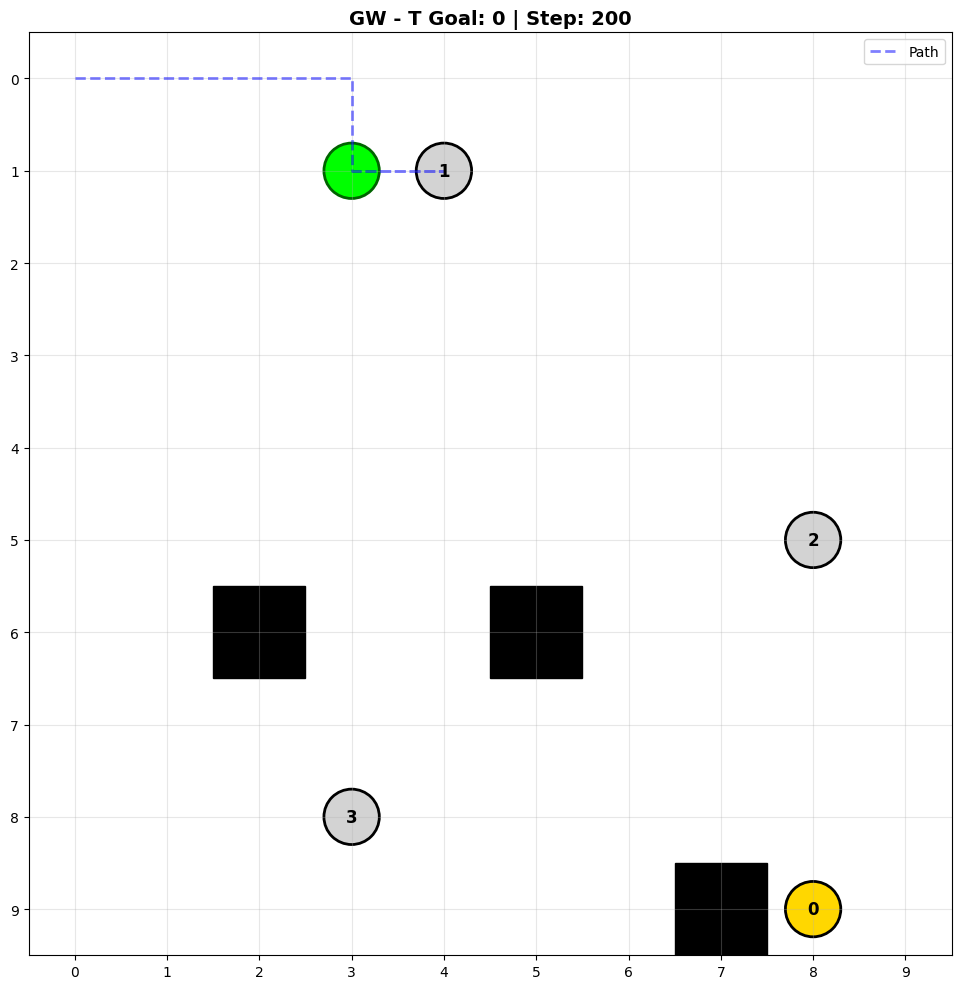

Creating key snapshots...

✓ Saved: gridworld_dqn_snapshots.png


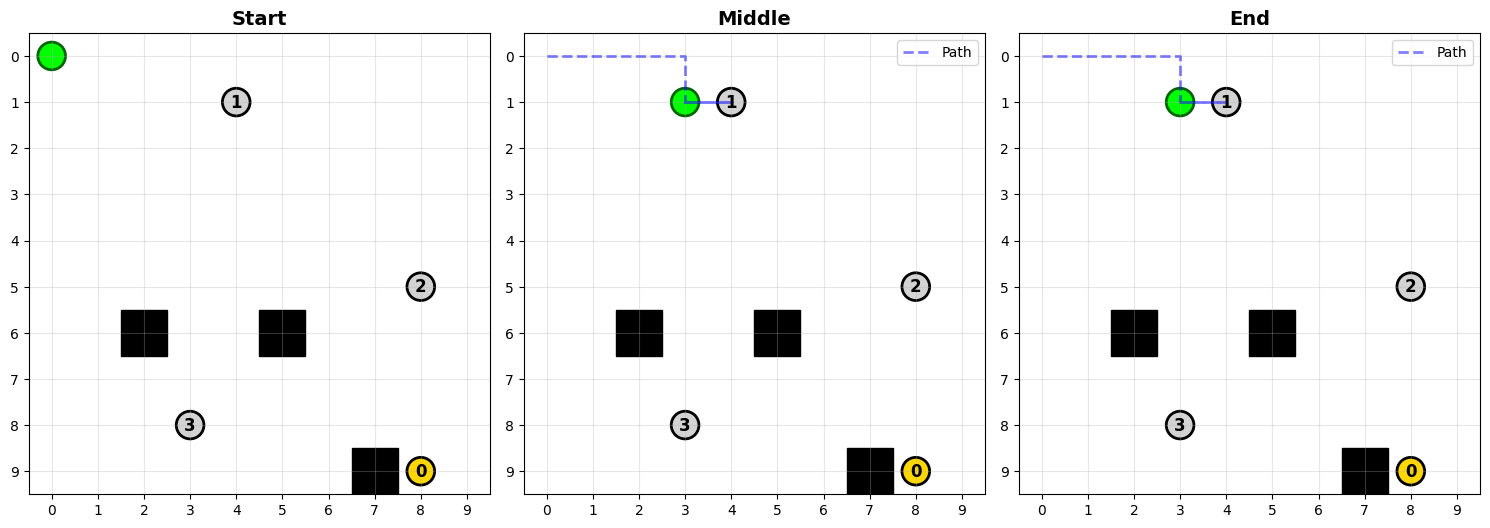

✓ Training metrics saved as 'gridworld_dqn_training.png'


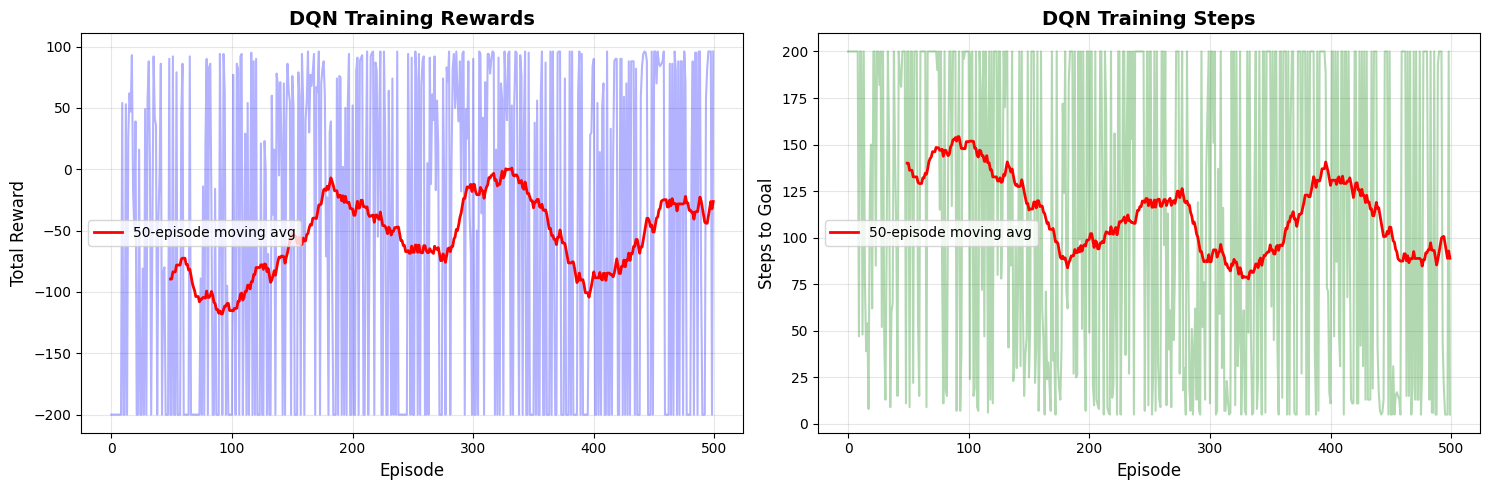


RESULTS:
Goal reached: False
Total steps taken: 200
Final position: [1 3]
Target goal position: [9 8]



In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from typing import Optional, Tuple, List
from collections import defaultdict, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MultiGoalGridWorld(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size: int = 10, target_goal: int = 0,
                 num_goals: int = 3, num_obstacles: int = 10):
        super().__init__()

        self.grid_size = grid_size
        self.num_goals = num_goals
        self.target_goal = target_goal
        self.num_obstacles = num_obstacles

        # Define action and observation space
        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.action_space = spaces.Discrete(4)

        # Observation: agent position (x, y)
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(2,), dtype=np.int32
        )

        # Initialize positions
        self.agent_pos = np.array([0, 0])
        self.goals = []
        self.obstacles = []
        self._generate_world()

    def _generate_world(self):
        self.goals = []
        self.obstacles = []

        # Get all available positions (excluding agent start)
        available_positions = [
            (x, y) for x in range(self.grid_size)
            for y in range(self.grid_size)
            if (x, y) != tuple(self.agent_pos)
        ]

        # Total positions needed
        total_needed = min(self.num_goals + self.num_obstacles, len(available_positions))

        # Randomly select positions
        selected_indices = np.random.choice(
            len(available_positions),
            size=total_needed,
            replace=False
        )

        # Assign goals
        for i in range(min(self.num_goals, total_needed)):
            idx = selected_indices[i]
            self.goals.append(np.array(available_positions[idx]))

        # Assign obstacles
        for i in range(self.num_goals, total_needed):
            idx = selected_indices[i]
            self.obstacles.append(np.array(available_positions[idx]))

    def _is_obstacle(self, pos: np.ndarray) -> bool:
        """Check if position contains an obstacle"""
        for obs in self.obstacles:
            if np.array_equal(pos, obs):
                return True
        return False

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)

        # Reset agent to fixed start position
        self.agent_pos = np.array([0, 0])

        # Ensure target_goal is valid
        if self.target_goal >= len(self.goals):
            self.target_goal = 0

        return self.agent_pos.copy(), {}

    def step(self, action: int):
        # Map actions to movements
        direction_map = {
            0: np.array([-1, 0]),  # UP
            1: np.array([0, 1]),   # RIGHT
            2: np.array([1, 0]),   # DOWN
            3: np.array([0, -1])   # LEFT
        }

        # Calculate new position
        new_pos = self.agent_pos + direction_map[action]

        # Check boundaries
        new_pos = np.clip(new_pos, 0, self.grid_size - 1)

        # Check if new position is an obstacle
        if not self._is_obstacle(new_pos):
            self.agent_pos = new_pos

        # Check if reached target goal
        target_pos = self.goals[self.target_goal]
        reached_goal = np.array_equal(self.agent_pos, target_pos)

        # Calculate reward
        if reached_goal:
            reward = 100.0
            terminated = True
        else:
            reward = -1.0  # Step penalty
            terminated = False

        truncated = False

        return self.agent_pos.copy(), reward, terminated, truncated, {}

    def render_grid(self, ax=None, agent_path=None, current_step=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.invert_yaxis()

        # Draw obstacles
        for obs in self.obstacles:
            rect = Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                           facecolor='black', edgecolor='black')
            ax.add_patch(rect)

        # Draw goals
        for idx, goal in enumerate(self.goals):
            color = 'gold' if idx == self.target_goal else 'lightgray'
            circle = Circle((goal[1], goal[0]), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(goal[1], goal[0], str(idx), ha='center', va='center',
                   fontsize=12, fontweight='bold')

        # Draw agent path if provided
        if agent_path and len(agent_path) > 1:
            path_array = np.array(agent_path)
            ax.plot(path_array[:, 1], path_array[:, 0], 'b--', alpha=0.5, linewidth=2, label='Path')

        # Draw agent
        agent_circle = Circle((self.agent_pos[1], self.agent_pos[0]), 0.3,
                             color='lime', ec='darkgreen', linewidth=2)
        ax.add_patch(agent_circle)

        title = f'GW - T Goal: {self.target_goal}'
        if current_step is not None:
            title += f' | Step: {current_step}'
        ax.set_title(title, fontsize=14, fontweight='bold')

        if agent_path and len(agent_path) > 1:
            ax.legend(loc='upper right')

        return ax


# Neural Network for Q-function approximation
class QNetwork(nn.Module):

    def __init__(self, state_size: int, action_size: int, hidden_sizes: List[int] = [128, 128]):
        super(QNetwork, self).__init__()

        layers = []
        input_size = state_size

        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        # Output layer
        layers.append(nn.Linear(input_size, action_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class ReplayBuffer:

    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class DQNAgent:

    def __init__(self, state_size: int, action_size: int,
                 learning_rate: float = 0.001,
                 discount_factor: float = 0.95,
                 epsilon: float = 1.0,
                 epsilon_decay: float = 0.995,
                 epsilon_min: float = 0.01,
                 buffer_size: int = 10000,
                 batch_size: int = 64,
                 target_update_freq: int = 10):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Device configuration
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Q-Networks
        self.q_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)

        # Convert state to tensor
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        with torch.no_grad():
            q_values = self.q_network(state_tensor)

        return q_values.argmax().item()

    def update(self, state: np.ndarray, action: int, reward: float,
               next_state: np.ndarray, done: bool):
        # Store experience in replay buffer
        self.replay_buffer.push(state, action, reward, next_state, done)

        # Train if enough samples
        if len(self.replay_buffer) >= self.batch_size:
            self._train_step()

    def _train_step(self):
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


def train_and_visualize(grid_size=10, num_goals=3, num_obstacles=15, episodes=500):

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=grid_size,
        target_goal=0,
        num_goals=num_goals,
        num_obstacles=num_obstacles
    )

    # Create DQN agent
    agent = DQNAgent(
        state_size=2,  # (x, y) position
        action_size=env.action_space.n,
        learning_rate=0.001,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=64,
        target_update_freq=10
    )

    # Training metrics
    episode_rewards = []
    episode_steps = []
    episode_goals = []

    print("Training DQN Agent with Changing Target Goals...")
    print(f"Grid Size: {grid_size}x{grid_size}")
    print(f"Number of Goals: {num_goals}")
    print(f"Number of Obstacles: {num_obstacles}")
    print(f"Episodes: {episodes}\n")

    # Training loop
    for episode in range(episodes):
        # Set a new random target goal for this episode
        env.target_goal = np.random.randint(0, num_goals)
        episode_goals.append(env.target_goal)

        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < 200:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}, "
                  f"Buffer Size: {len(agent.replay_buffer)}")

    print("\n✓ Training Complete!\n")

    # Test the trained agent
    print("Testing Trained Agent (ALL Steps Visualization)...")
    env.target_goal = np.random.randint(0, num_goals)
    print(f"Testing with Target Goal: {env.target_goal}")
    state, _ = env.reset()
    done = False
    steps = 0
    agent_path = [state.copy()]
    all_positions = [state.copy()]

    while not done and steps < 200:
        action = agent.get_action(state)
        agent.epsilon = 0  # Greedy policy

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent_path.append(next_state.copy())
        all_positions.append(next_state.copy())
        state = next_state
        steps += 1

    print(f"Agent took {steps} steps to reach the goal!")

    # Create a single visualization showing the complete path
    print("Creating final path visualization...\n")

    fig, ax = plt.subplots(figsize=(10, 10))
    env.agent_pos = all_positions[-1]  # Set to final position
    env.render_grid(ax, agent_path=all_positions, current_step=steps)

    plt.tight_layout()
    filename = 'gridworld_dqn_final_path.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    plt.show()

    # Optional: Create key snapshots (start, middle, end)
    print("Creating key snapshots...\n")
    key_indices = [0, len(all_positions)//2, len(all_positions)-1]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, step_idx in enumerate(key_indices):
        env.agent_pos = all_positions[step_idx]
        current_path = all_positions[:step_idx + 1]
        env.render_grid(axes[idx], agent_path=current_path, current_step=step_idx)
        if idx == 0:
            axes[idx].set_title('Start', fontsize=14, fontweight='bold')
        elif idx == 1:
            axes[idx].set_title('Middle', fontsize=14, fontweight='bold')
        else:
            axes[idx].set_title('End', fontsize=14, fontweight='bold')

    plt.tight_layout()
    filename = 'gridworld_dqn_snapshots.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    plt.show()

    # Plot training metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(episode_rewards, alpha=0.3, color='blue')
    window = 50
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('DQN Training Rewards', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(episode_steps, alpha=0.3, color='green')
    if len(episode_steps) >= window:
        moving_avg = np.convolve(episode_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_steps)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Steps to Goal', fontsize=12)
    ax2.set_title('DQN Training Steps', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('gridworld_dqn_training.png', dpi=150, bbox_inches='tight')
    print(f"✓ Training metrics saved as 'gridworld_dqn_training.png'")
    plt.show()

    print(f"\n{'='*60}")
    print(f"RESULTS:")
    print(f"{'='*60}")
    print(f"Goal reached: {done}")
    print(f"Total steps taken: {steps}")
    print(f"Final position: {state}")
    print(f"Target goal position: {env.goals[env.target_goal]}")
    print(f"{'='*60}\n")

    return env, agent, episode_rewards, episode_steps, episode_goals


if __name__ == "__main__":
    env, agent, rewards, steps, goals = train_and_visualize(
        grid_size=10,
        num_goals=4,
        num_obstacles=3,
        episodes=500
    )

Using device: cpu
Training DQN Agent with Changing Target Goals...
Grid Size: 10x10
Number of Goals: 4
Number of Obstacles: 3
Episodes: 500

Episode 100/500 - Avg Reward: -50.70, Avg Steps: 112.31, Epsilon: 0.606, Buffer Size: 10000
Episode 200/500 - Avg Reward: -67.90, Avg Steps: 120.42, Epsilon: 0.367, Buffer Size: 10000
Episode 300/500 - Avg Reward: -19.72, Avg Steps: 90.42, Epsilon: 0.222, Buffer Size: 10000
Episode 400/500 - Avg Reward: 28.09, Avg Steps: 61.80, Epsilon: 0.135, Buffer Size: 10000
Episode 500/500 - Avg Reward: 21.45, Avg Steps: 63.39, Epsilon: 0.082, Buffer Size: 10000

✓ Training Complete!

Testing Trained Agent (ALL Steps Visualization)...
Testing with Target Goal: 1
Agent took 200 steps to reach the goal!
Creating visualization for ALL 200 steps...

Generating figure 1/5 (Steps 0 to 47)...
✓ Saved: gridworld_dqn_steps_part1.png


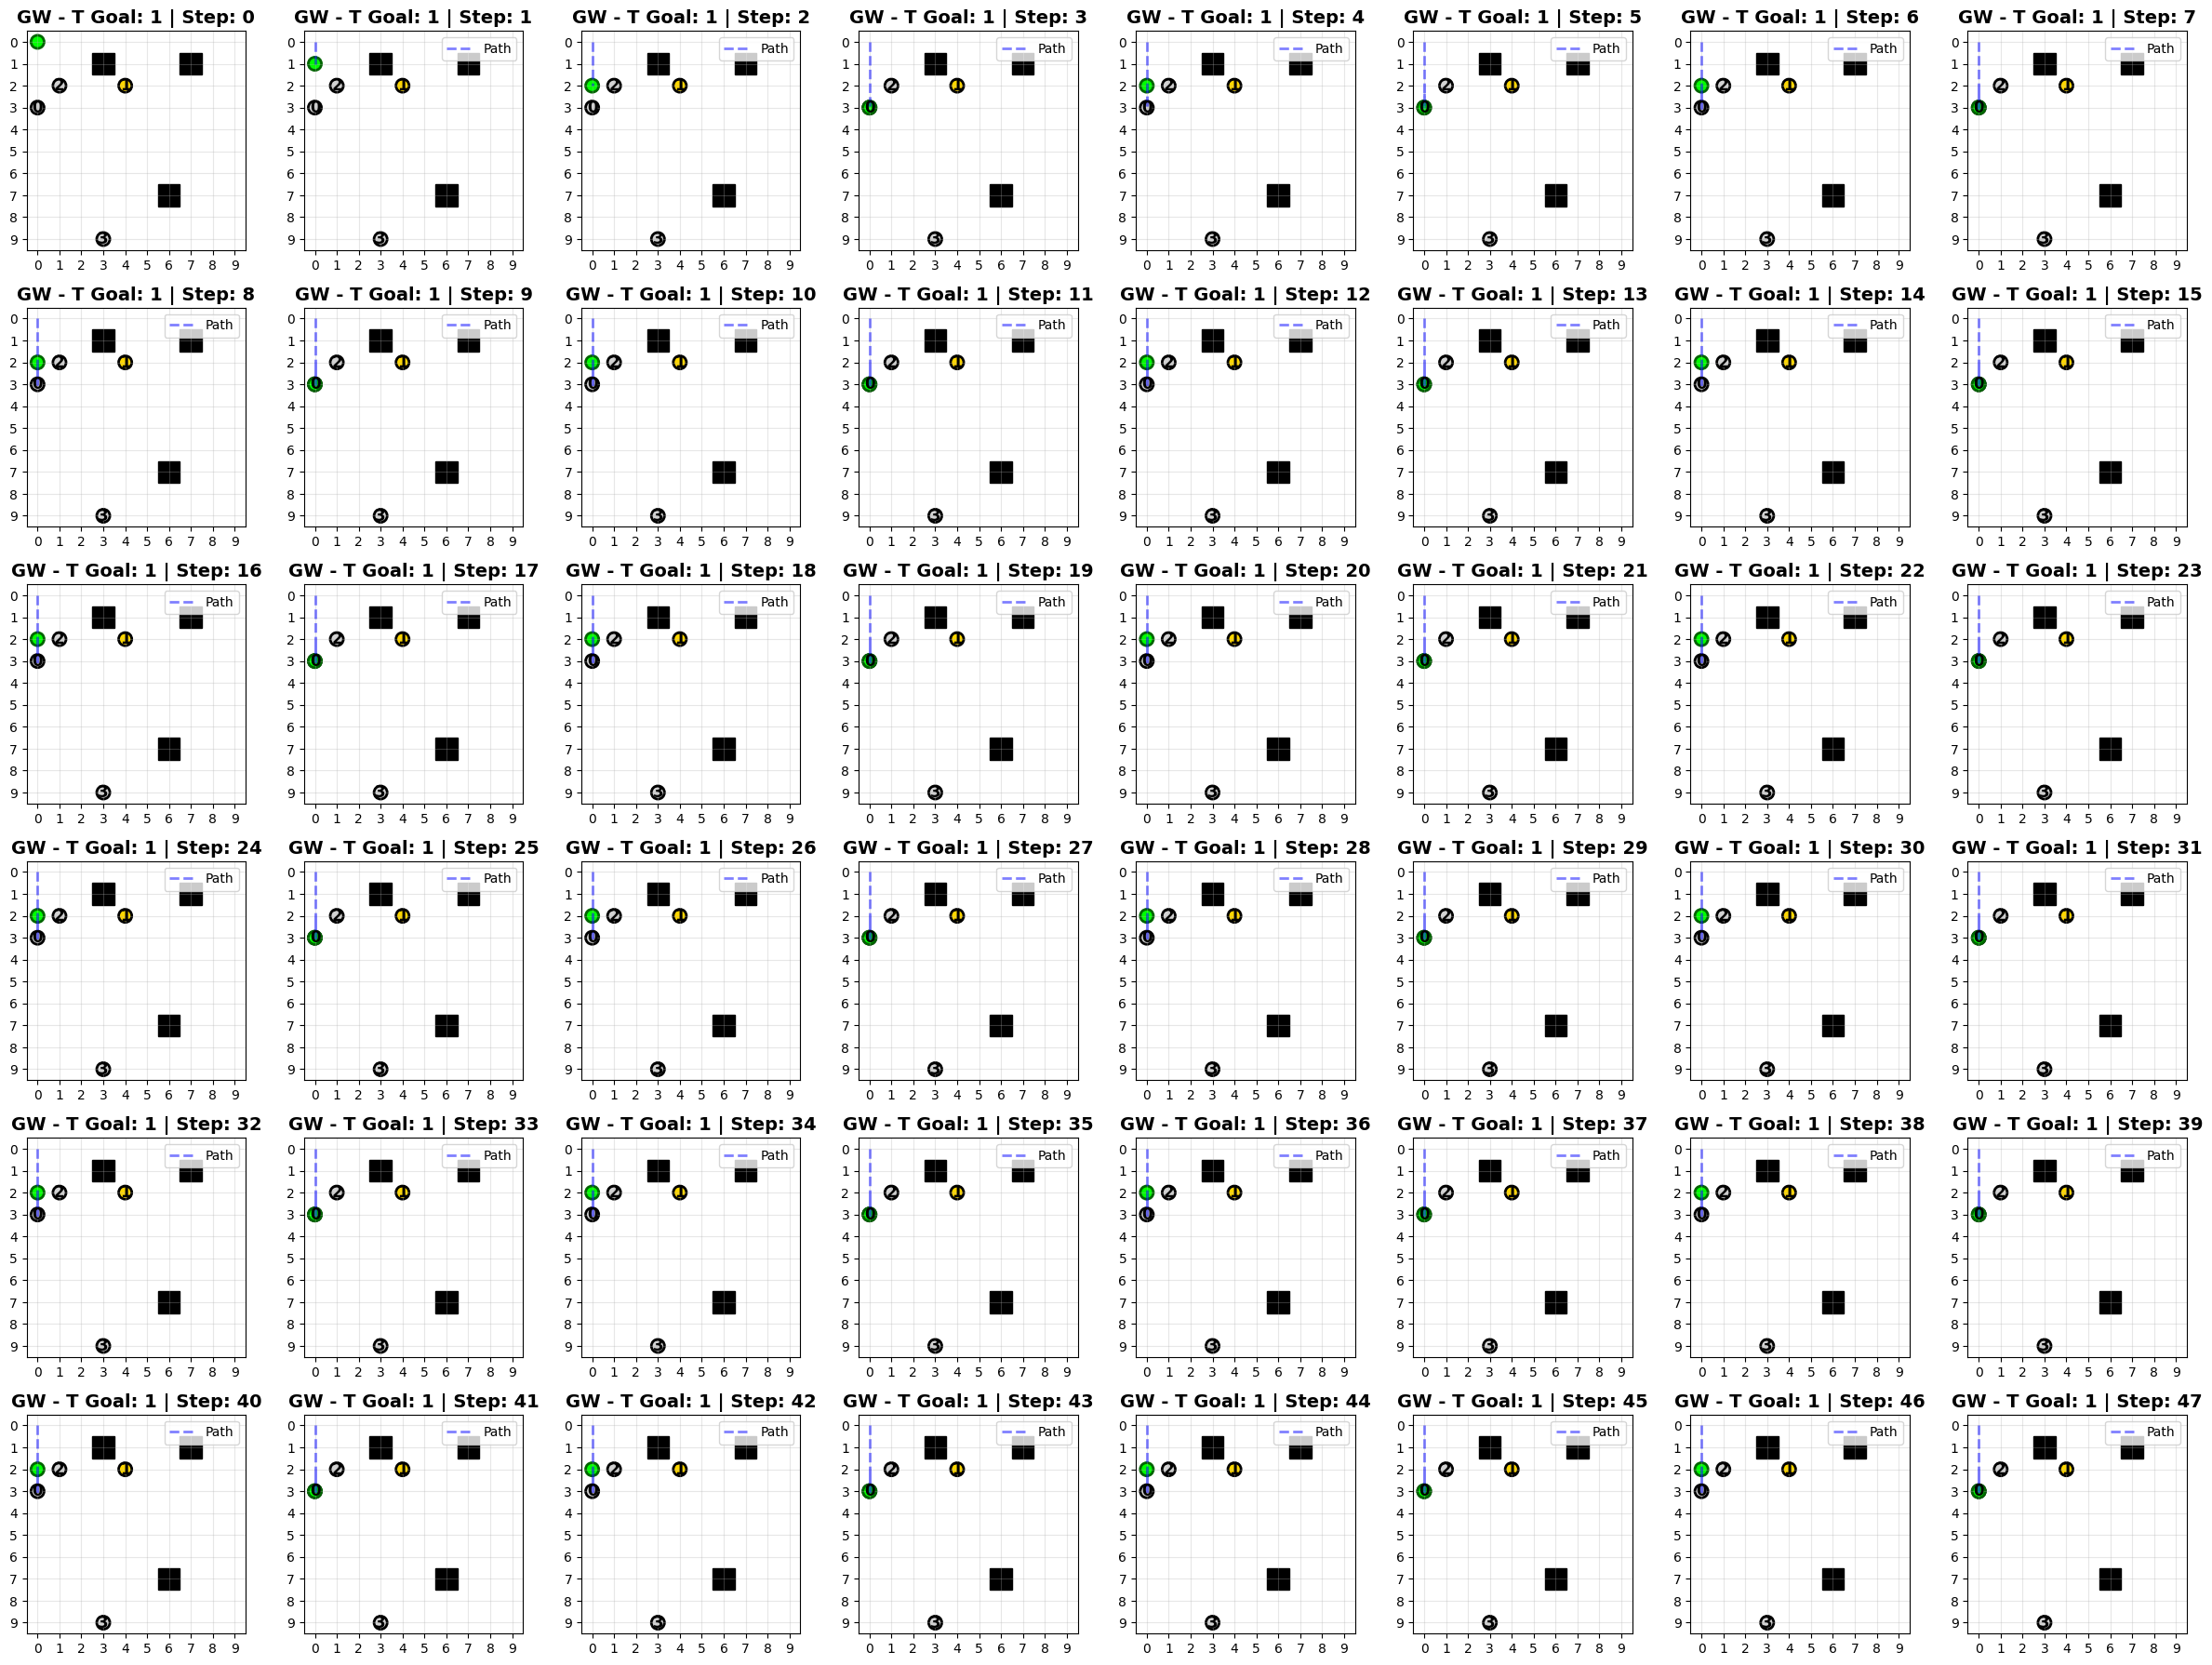

Generating figure 2/5 (Steps 48 to 95)...
✓ Saved: gridworld_dqn_steps_part2.png


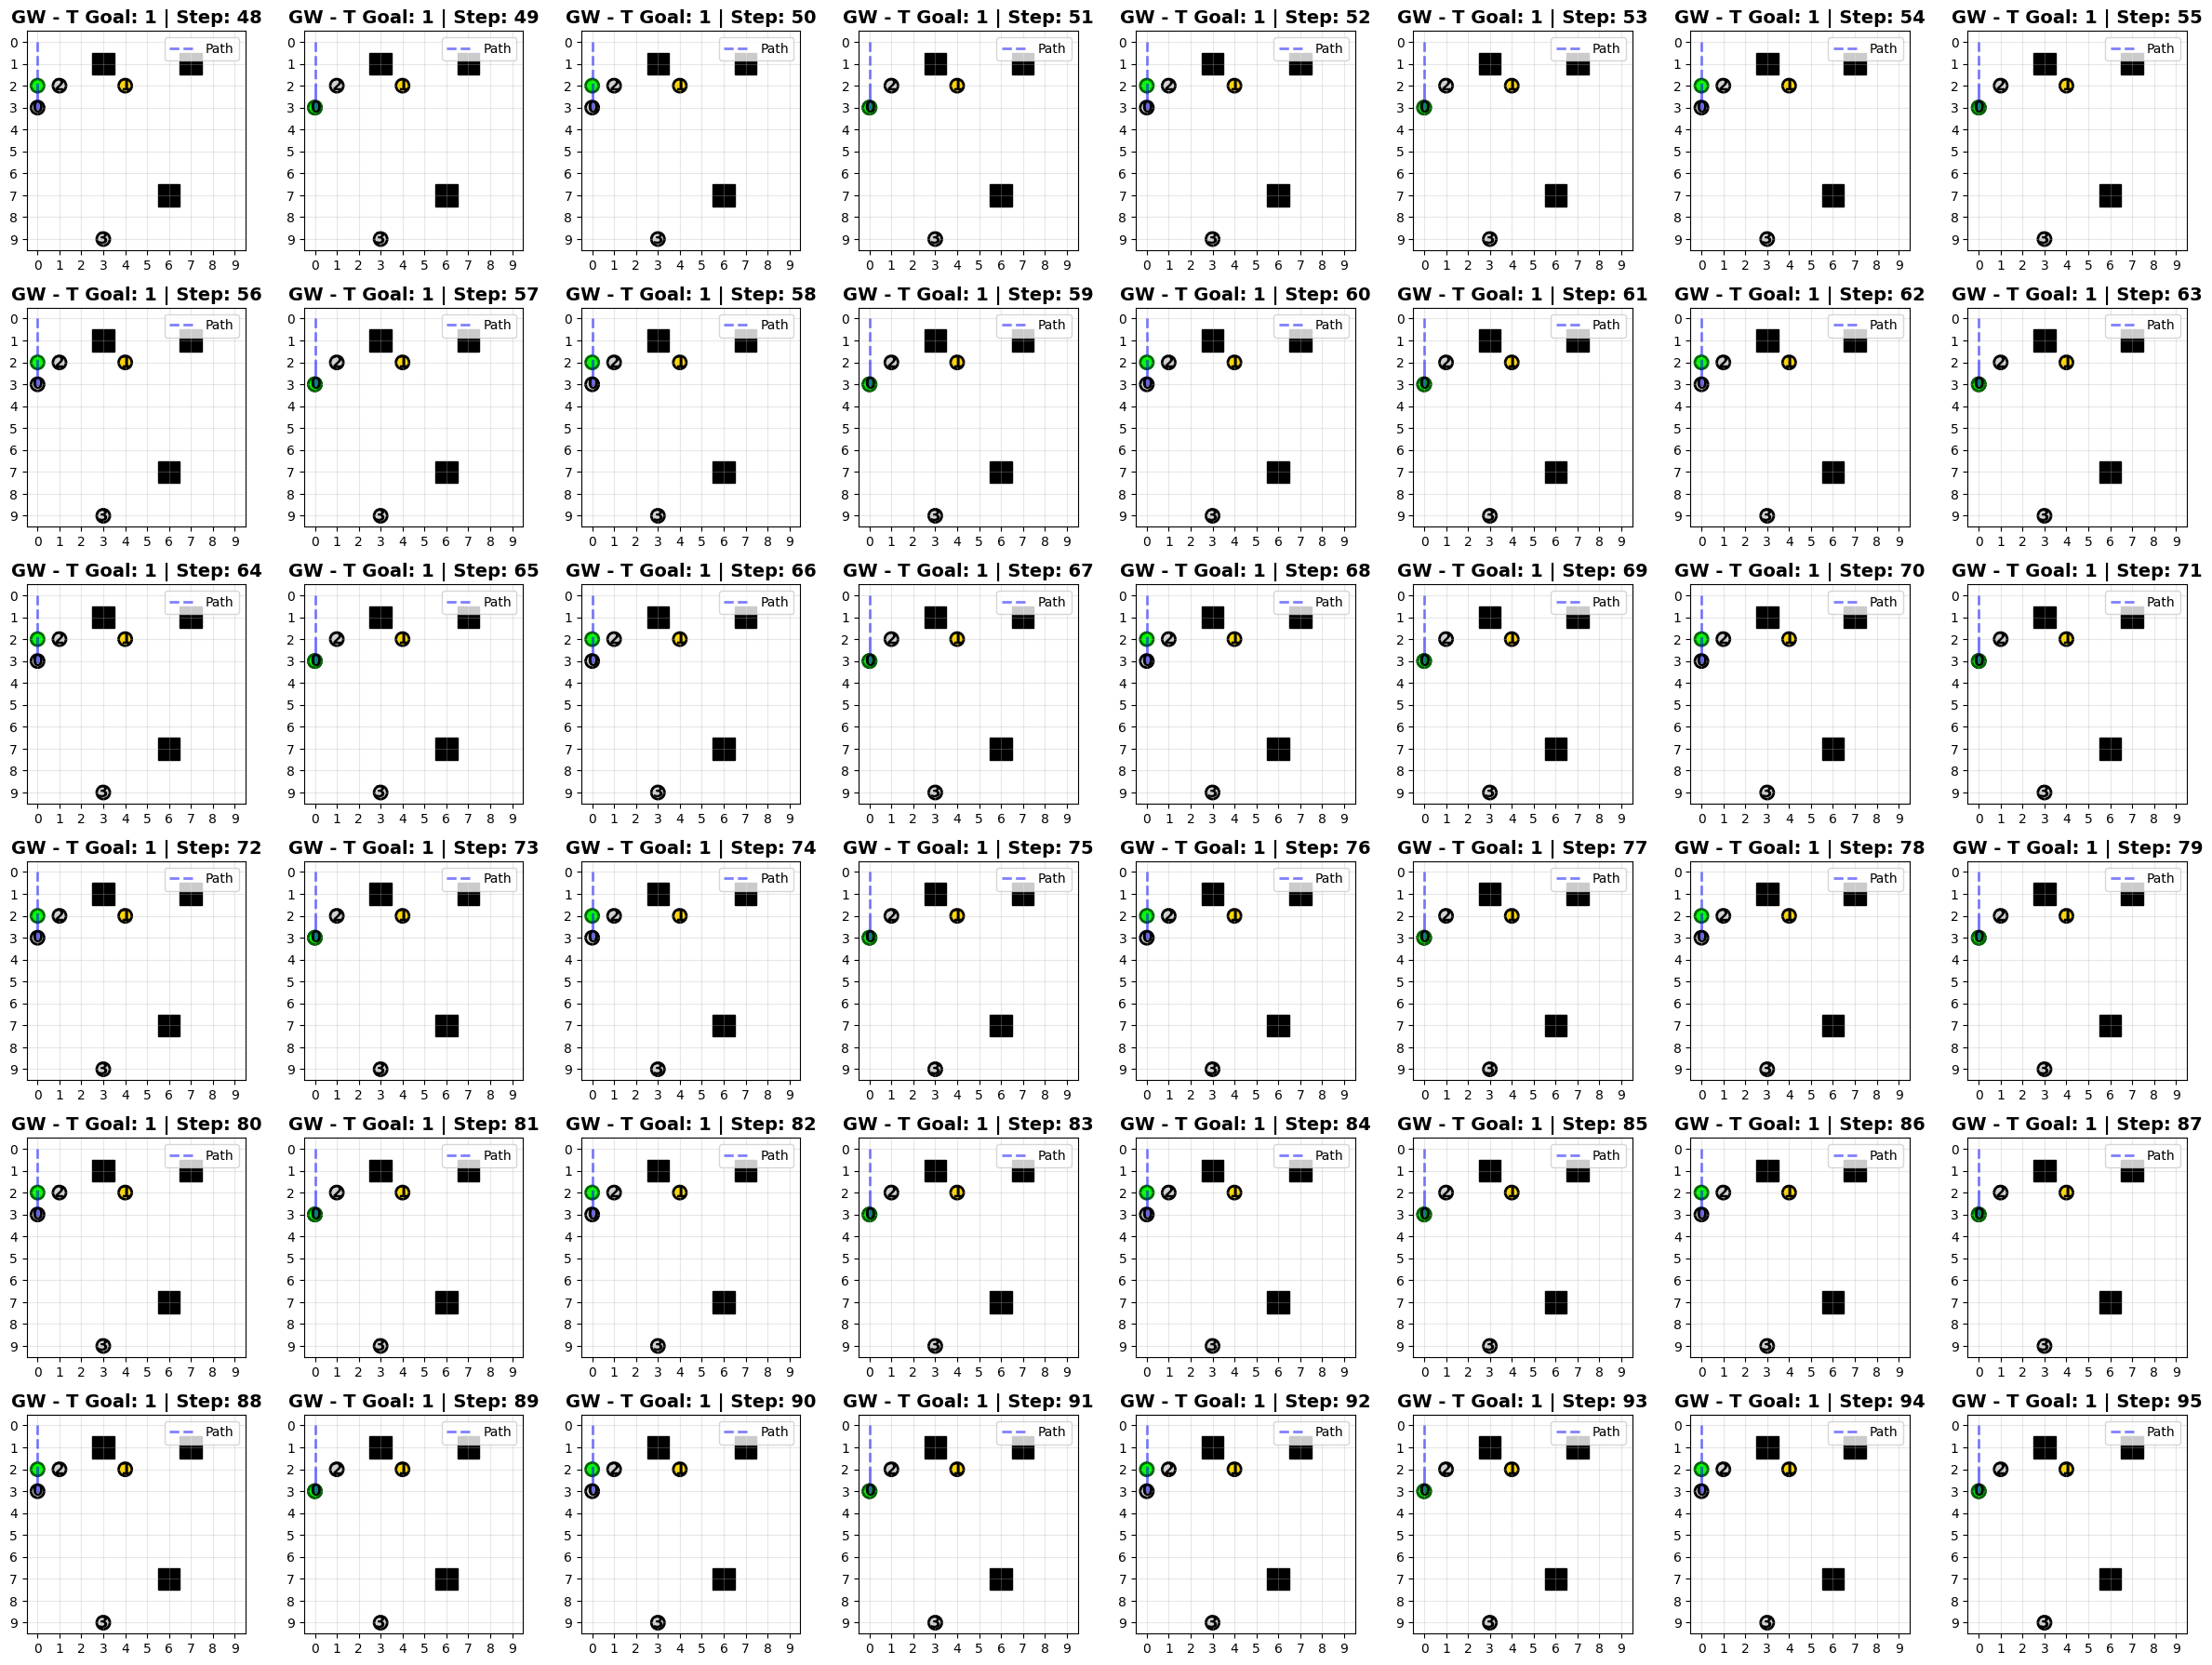

Generating figure 3/5 (Steps 96 to 143)...
✓ Saved: gridworld_dqn_steps_part3.png


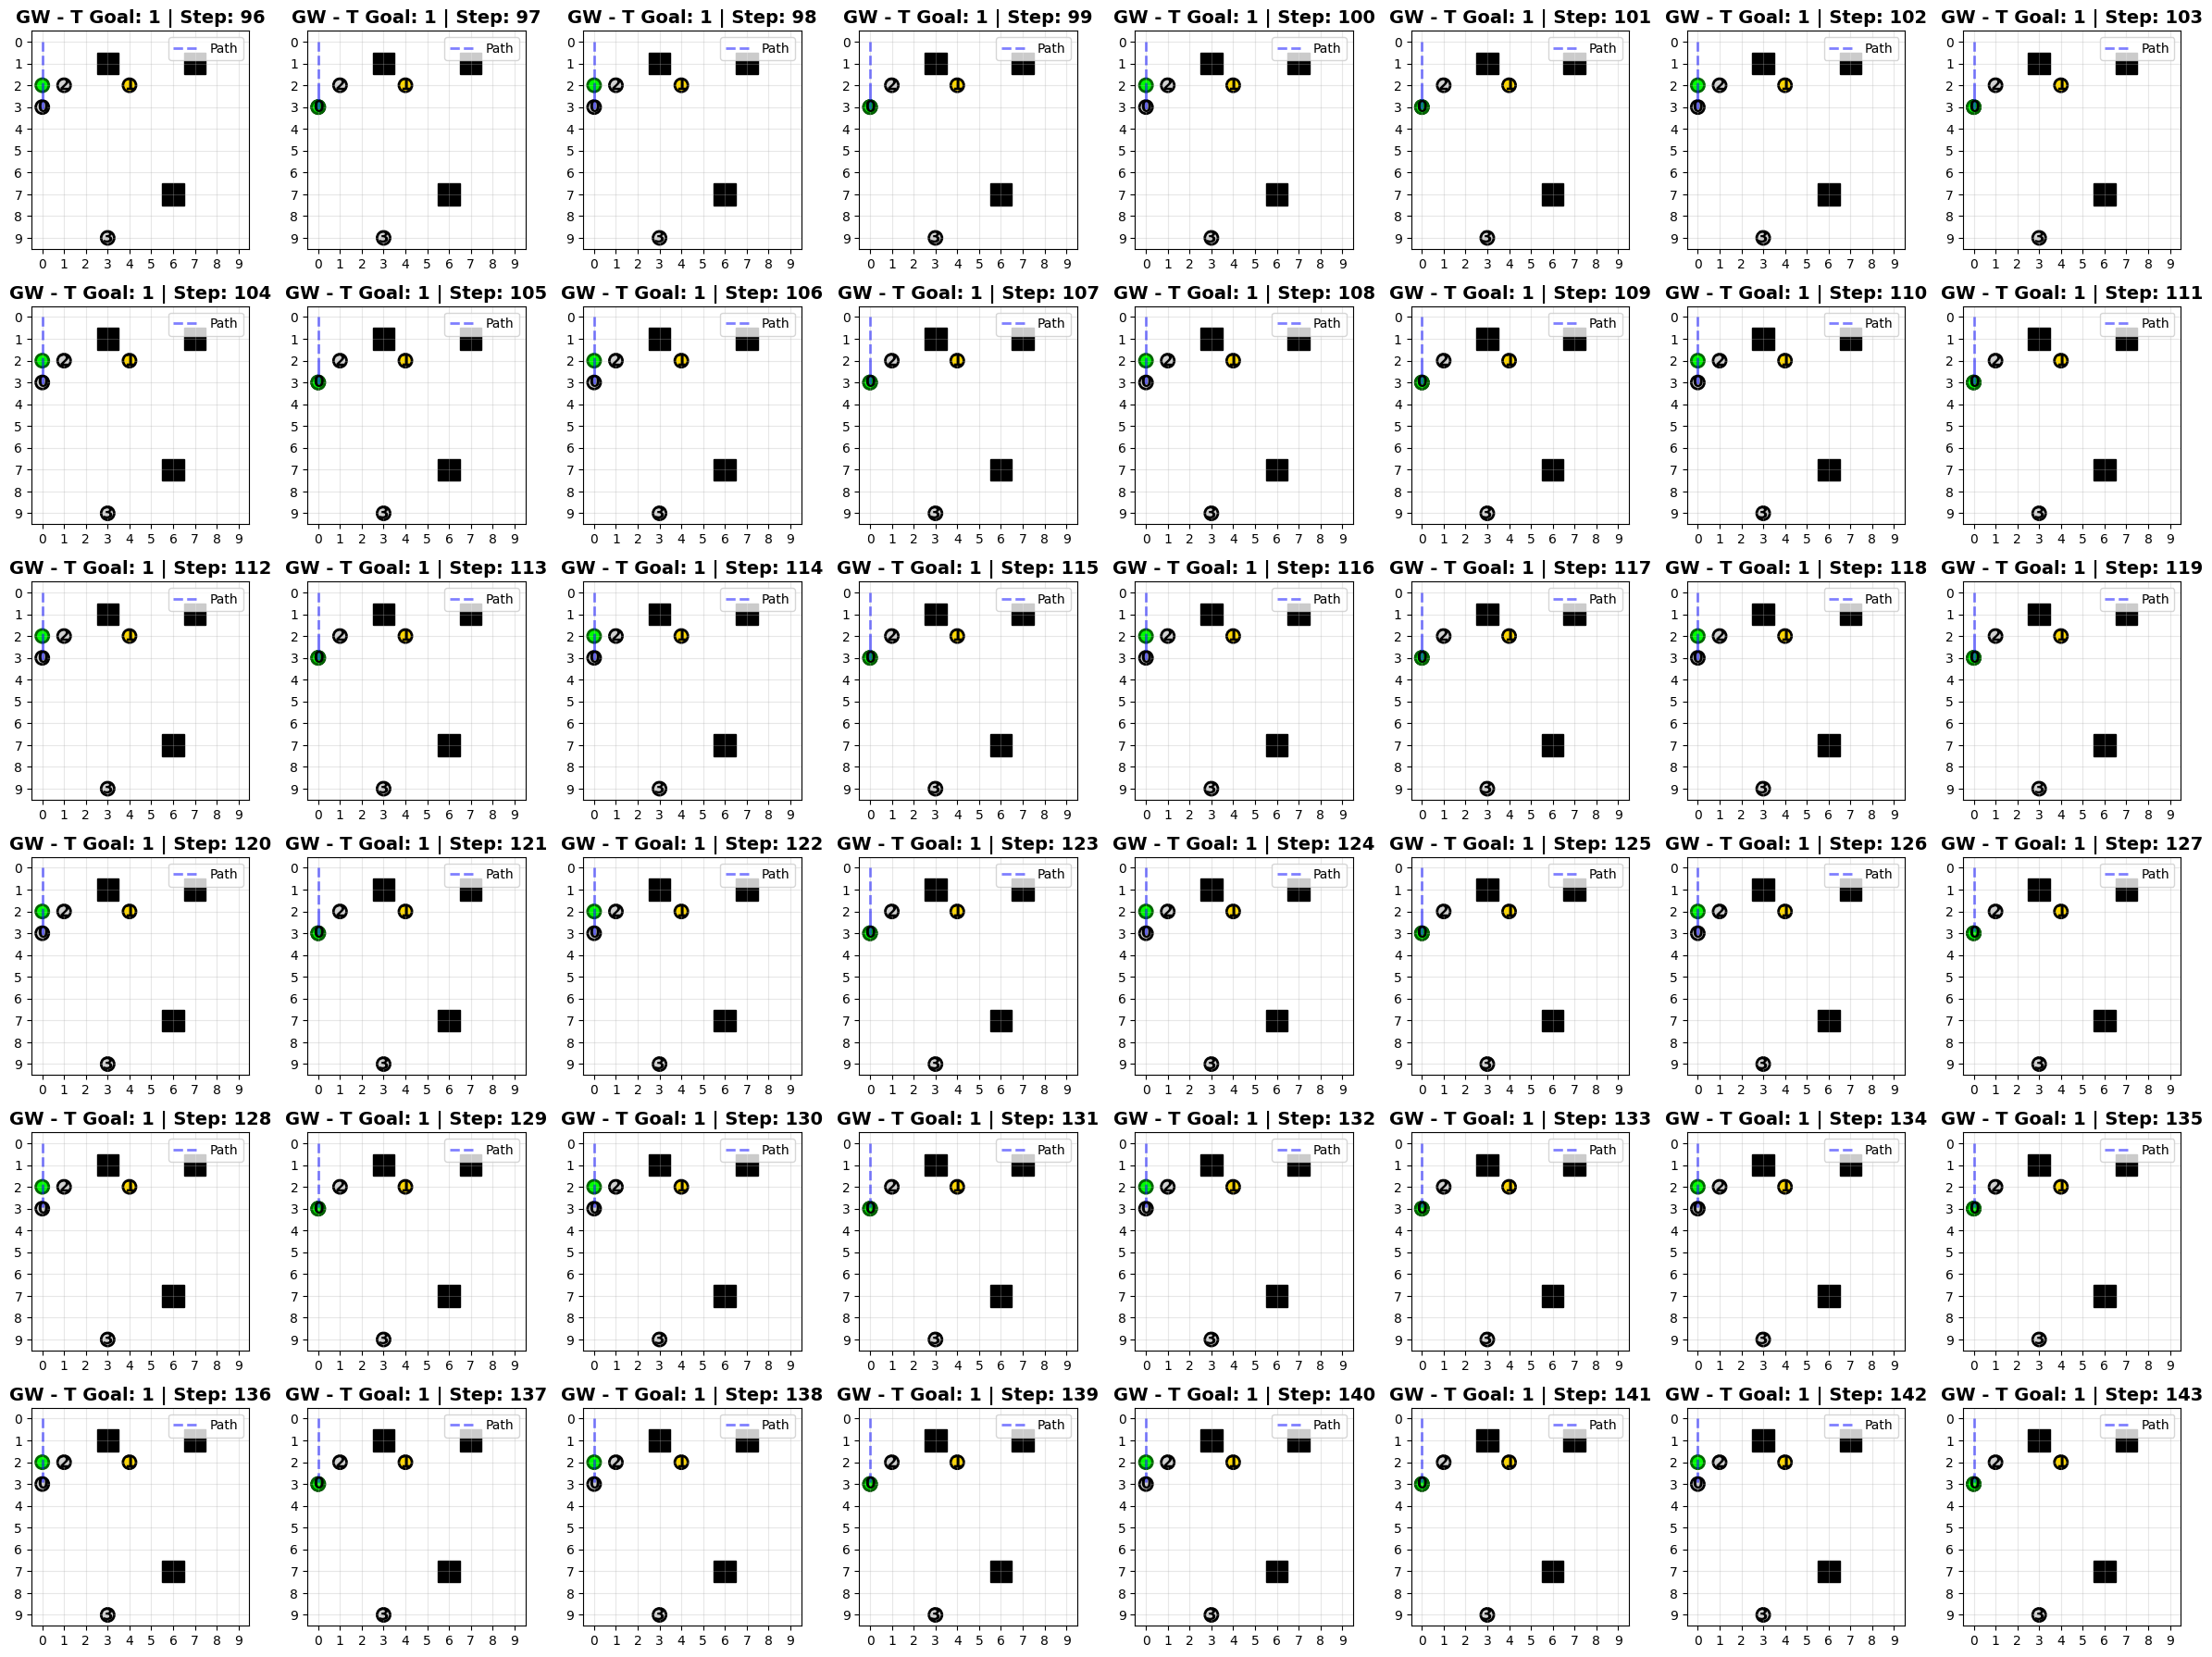

Generating figure 4/5 (Steps 144 to 191)...
✓ Saved: gridworld_dqn_steps_part4.png


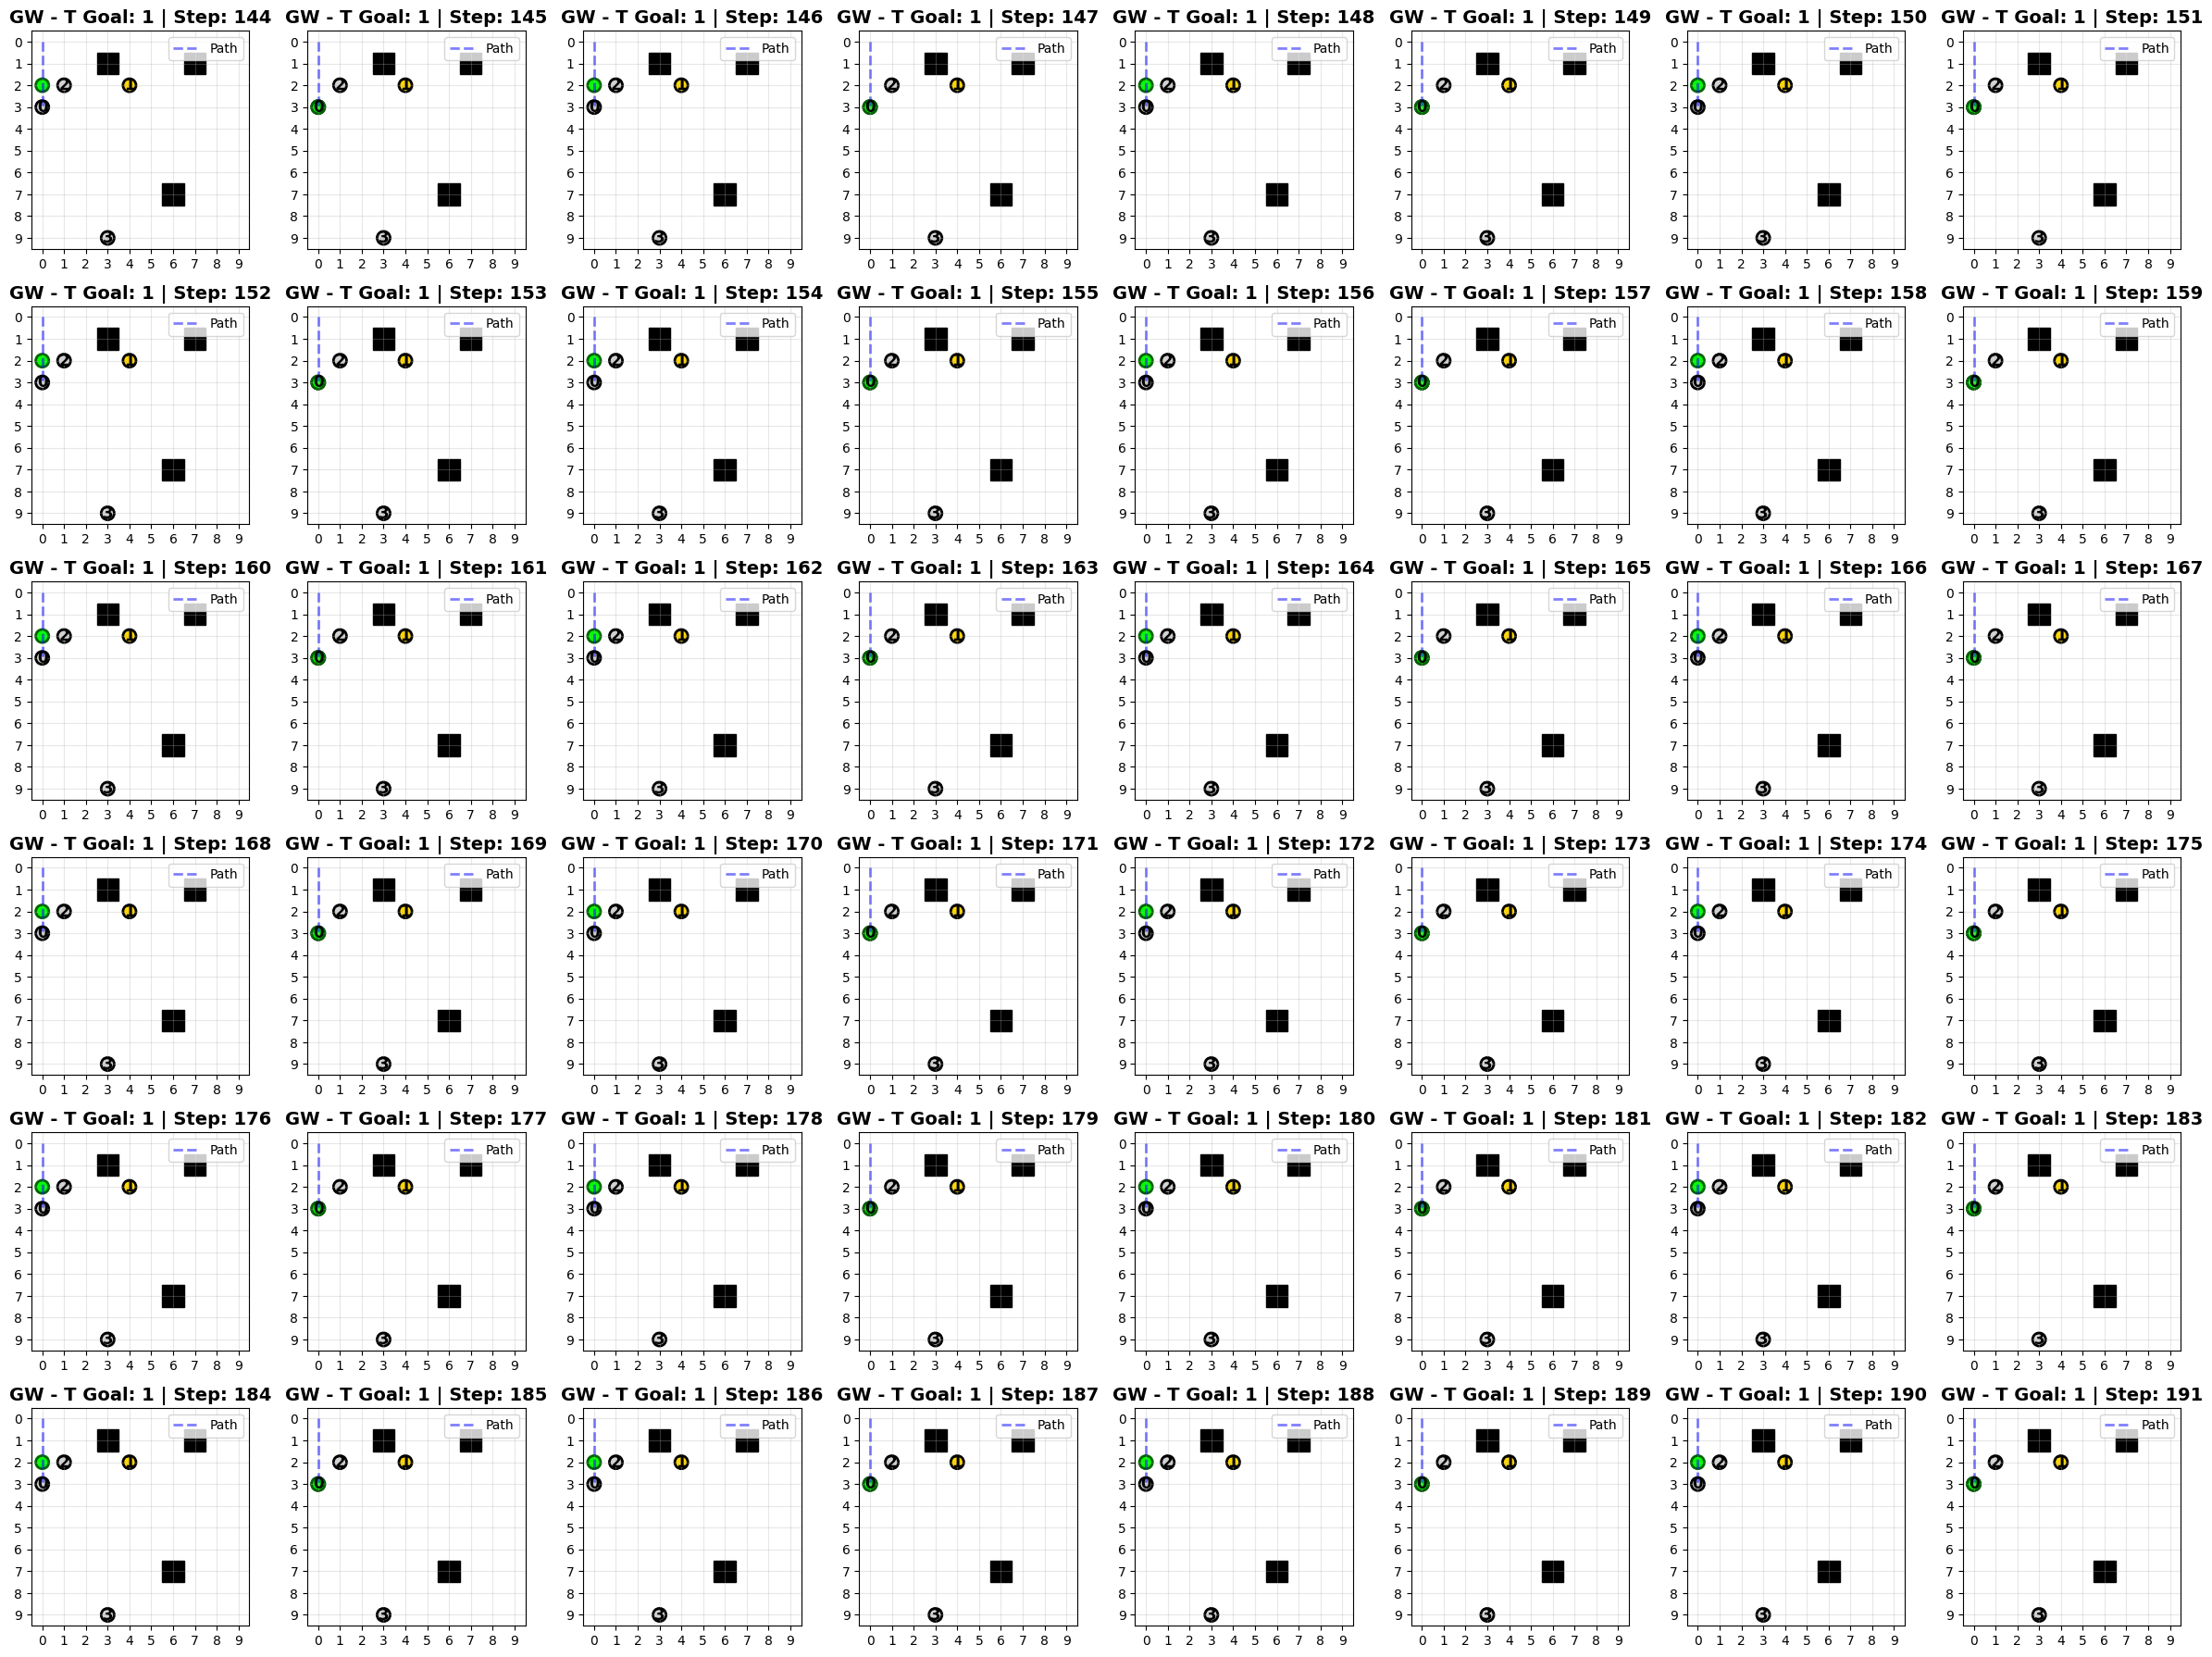

Generating figure 5/5 (Steps 192 to 200)...
✓ Saved: gridworld_dqn_steps_part5.png


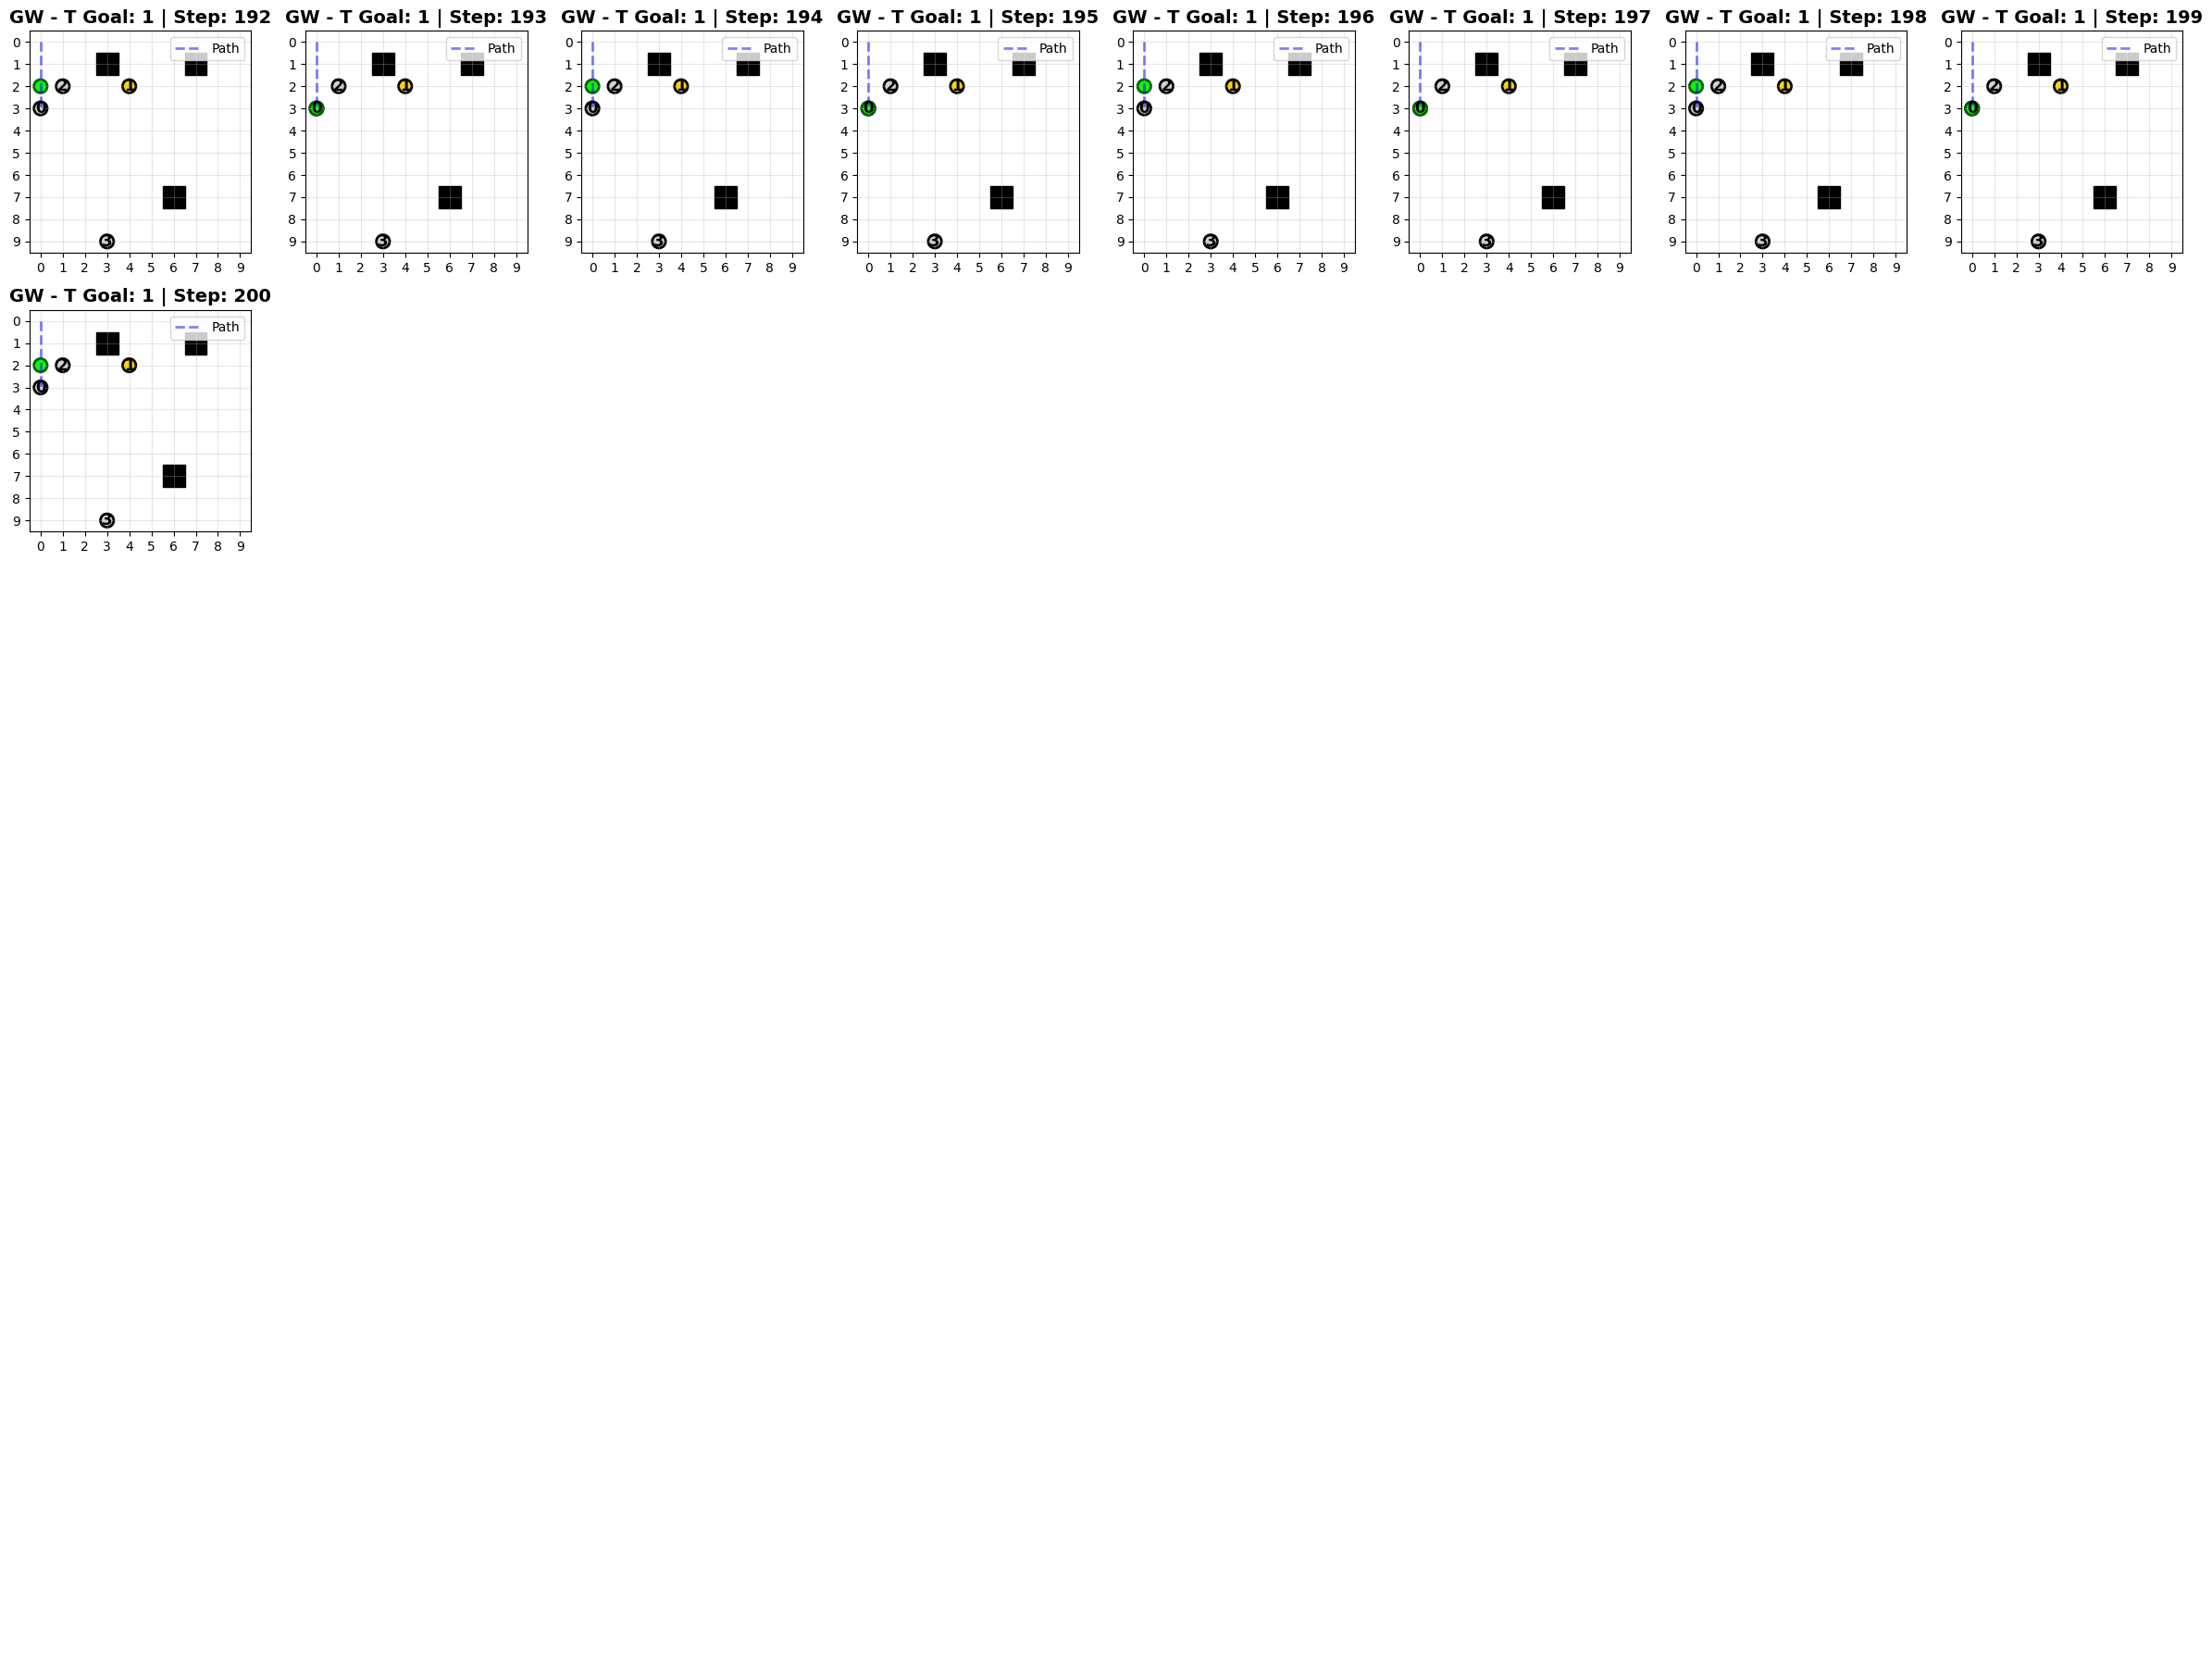

✓ Training metrics saved as 'gridworld_dqn_training.png'


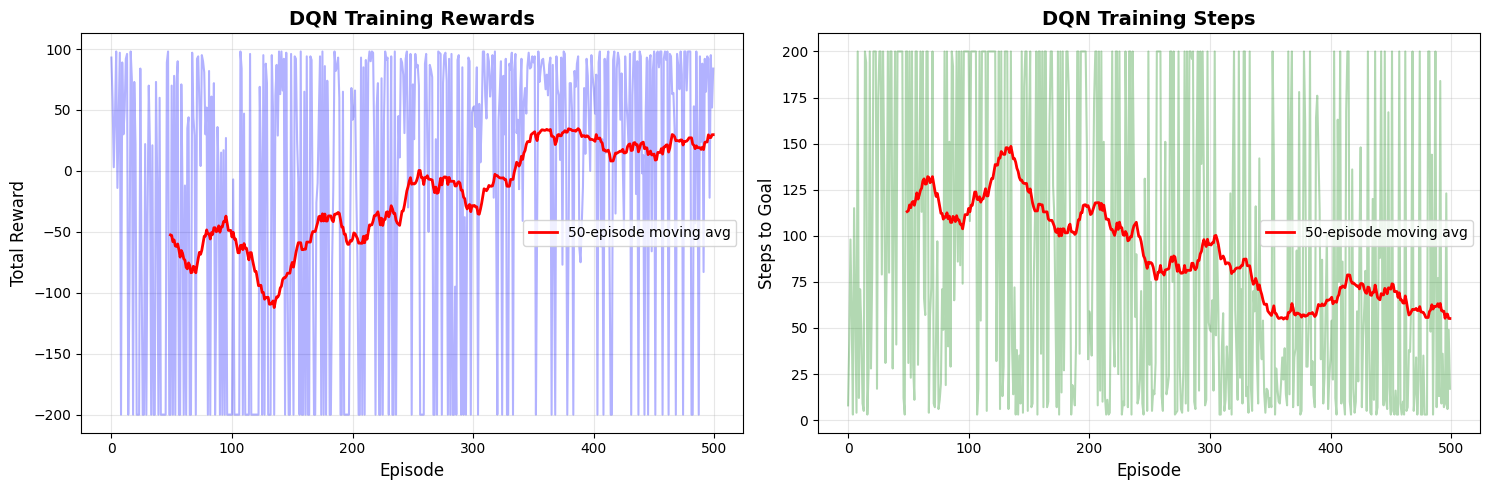


RESULTS:
Goal reached: False
Total steps taken: 200
Final position: [2 0]
Target goal position: [2 4]



In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from typing import Optional, Tuple, List
from collections import defaultdict, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MultiGoalGridWorld(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size: int = 10, target_goal: int = 0,
                 num_goals: int = 3, num_obstacles: int = 10):
        super().__init__()

        self.grid_size = grid_size
        self.num_goals = num_goals
        self.target_goal = target_goal
        self.num_obstacles = num_obstacles

        # Define action and observation space
        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.action_space = spaces.Discrete(4)

        # Observation: agent position (x, y)
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(2,), dtype=np.int32
        )

        # Initialize positions
        self.agent_pos = np.array([0, 0])
        self.goals = []
        self.obstacles = []
        self._generate_world()

    def _generate_world(self):
        self.goals = []
        self.obstacles = []

        # Get all available positions (excluding agent start)
        available_positions = [
            (x, y) for x in range(self.grid_size)
            for y in range(self.grid_size)
            if (x, y) != tuple(self.agent_pos)
        ]

        # Total positions needed
        total_needed = min(self.num_goals + self.num_obstacles, len(available_positions))

        # Randomly select positions
        selected_indices = np.random.choice(
            len(available_positions),
            size=total_needed,
            replace=False
        )

        # Assign goals
        for i in range(min(self.num_goals, total_needed)):
            idx = selected_indices[i]
            self.goals.append(np.array(available_positions[idx]))

        # Assign obstacles
        for i in range(self.num_goals, total_needed):
            idx = selected_indices[i]
            self.obstacles.append(np.array(available_positions[idx]))

    def _is_obstacle(self, pos: np.ndarray) -> bool:
        for obs in self.obstacles:
            if np.array_equal(pos, obs):
                return True
        return False

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)

        # Reset agent to fixed start position
        self.agent_pos = np.array([0, 0])

        # Ensure target_goal is valid
        if self.target_goal >= len(self.goals):
            self.target_goal = 0

        return self.agent_pos.copy(), {}

    def step(self, action: int):
        # Map actions to movements
        direction_map = {
            0: np.array([-1, 0]),  # UP
            1: np.array([0, 1]),   # RIGHT
            2: np.array([1, 0]),   # DOWN
            3: np.array([0, -1])   # LEFT
        }

        # Calculate new position
        new_pos = self.agent_pos + direction_map[action]

        # Check boundaries
        new_pos = np.clip(new_pos, 0, self.grid_size - 1)

        # Check if new position is an obstacle
        if not self._is_obstacle(new_pos):
            self.agent_pos = new_pos

        # Check if reached target goal
        target_pos = self.goals[self.target_goal]
        reached_goal = np.array_equal(self.agent_pos, target_pos)

        # Calculate reward
        if reached_goal:
            reward = 100.0
            terminated = True
        else:
            reward = -1.0  # Step penalty
            terminated = False

        truncated = False

        return self.agent_pos.copy(), reward, terminated, truncated, {}

    def render_grid(self, ax=None, agent_path=None, current_step=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.invert_yaxis()

        # Draw obstacles
        for obs in self.obstacles:
            rect = Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                           facecolor='black', edgecolor='black')
            ax.add_patch(rect)

        # Draw goals
        for idx, goal in enumerate(self.goals):
            color = 'gold' if idx == self.target_goal else 'lightgray'
            circle = Circle((goal[1], goal[0]), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(goal[1], goal[0], str(idx), ha='center', va='center',
                   fontsize=12, fontweight='bold')

        # Draw agent path if provided
        if agent_path and len(agent_path) > 1:
            path_array = np.array(agent_path)
            ax.plot(path_array[:, 1], path_array[:, 0], 'b--', alpha=0.5, linewidth=2, label='Path')

        # Draw agent
        agent_circle = Circle((self.agent_pos[1], self.agent_pos[0]), 0.3,
                             color='lime', ec='darkgreen', linewidth=2)
        ax.add_patch(agent_circle)

        title = f'GW - T Goal: {self.target_goal}'
        if current_step is not None:
            title += f' | Step: {current_step}'
        ax.set_title(title, fontsize=14, fontweight='bold')

        if agent_path and len(agent_path) > 1:
            ax.legend(loc='upper right')

        return ax


# Neural Network for Q-function approximation
class QNetwork(nn.Module):

    def __init__(self, state_size: int, action_size: int, hidden_sizes: List[int] = [128, 128]):
        super(QNetwork, self).__init__()

        layers = []
        input_size = state_size

        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        # Output layer
        layers.append(nn.Linear(input_size, action_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class ReplayBuffer:

    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class DQNAgent:

    def __init__(self, state_size: int, action_size: int,
                 learning_rate: float = 0.001,
                 discount_factor: float = 0.95,
                 epsilon: float = 1.0,
                 epsilon_decay: float = 0.995,
                 epsilon_min: float = 0.01,
                 buffer_size: int = 10000,
                 batch_size: int = 64,
                 target_update_freq: int = 10):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Device configuration
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Q-Networks
        self.q_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)

        # Convert state to tensor
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        with torch.no_grad():
            q_values = self.q_network(state_tensor)

        return q_values.argmax().item()

    def update(self, state: np.ndarray, action: int, reward: float,
               next_state: np.ndarray, done: bool):
        # Store experience in replay buffer
        self.replay_buffer.push(state, action, reward, next_state, done)

        # Train if enough samples
        if len(self.replay_buffer) >= self.batch_size:
            self._train_step()

    def _train_step(self):
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


def train_and_visualize(grid_size=10, num_goals=3, num_obstacles=15, episodes=500):

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=grid_size,
        target_goal=0,
        num_goals=num_goals,
        num_obstacles=num_obstacles
    )

    # Create DQN agent
    agent = DQNAgent(
        state_size=2,  # (x, y) position
        action_size=env.action_space.n,
        learning_rate=0.001,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=64,
        target_update_freq=10
    )

    # Training metrics
    episode_rewards = []
    episode_steps = []
    episode_goals = []

    print("Training DQN Agent with Changing Target Goals...")
    print(f"Grid Size: {grid_size}x{grid_size}")
    print(f"Number of Goals: {num_goals}")
    print(f"Number of Obstacles: {num_obstacles}")
    print(f"Episodes: {episodes}\n")

    # Training loop
    for episode in range(episodes):
        # Set a new random target goal for this episode
        env.target_goal = np.random.randint(0, num_goals)
        episode_goals.append(env.target_goal)

        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < 200:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}, "
                  f"Buffer Size: {len(agent.replay_buffer)}")

    print("\n✓ Training Complete!\n")

    # Test the trained agent
    print("Testing Trained Agent (ALL Steps Visualization)...")
    env.target_goal = np.random.randint(0, num_goals)
    print(f"Testing with Target Goal: {env.target_goal}")
    state, _ = env.reset()
    done = False
    steps = 0
    agent_path = [state.copy()]
    all_positions = [state.copy()]

    while not done and steps < 200:
        action = agent.get_action(state)
        agent.epsilon = 0  # Greedy policy

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent_path.append(next_state.copy())
        all_positions.append(next_state.copy())
        state = next_state
        steps += 1

    print(f"Agent took {steps} steps to reach the goal!")
    print(f"Creating visualization for ALL {steps} steps...\n")

    # Visualization code (same as before)
    total_steps = len(all_positions)

    if total_steps <= 6:
        rows, cols = 2, 3
    elif total_steps <= 12:
        rows, cols = 3, 4
    elif total_steps <= 20:
        rows, cols = 4, 5
    elif total_steps <= 30:
        rows, cols = 5, 6
    else:
        rows, cols = 6, 8

    steps_per_figure = rows * cols
    num_figures = (total_steps + steps_per_figure - 1) // steps_per_figure

    for fig_num in range(num_figures):
        start_idx = fig_num * steps_per_figure
        end_idx = min(start_idx + steps_per_figure, total_steps)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()

        print(f"Generating figure {fig_num + 1}/{num_figures} (Steps {start_idx} to {end_idx - 1})...")

        for i in range(steps_per_figure):
            ax = axes[i]
            step_idx = start_idx + i

            if step_idx < total_steps:
                env.agent_pos = all_positions[step_idx]
                current_path = all_positions[:step_idx + 1]
                env.render_grid(ax, agent_path=current_path, current_step=step_idx)
            else:
                ax.axis('off')

        plt.tight_layout()
        filename = f'gridworld_dqn_steps_part{fig_num + 1}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {filename}")
        plt.show()

    # Plot training metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(episode_rewards, alpha=0.3, color='blue')
    window = 50
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('DQN Training Rewards', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(episode_steps, alpha=0.3, color='green')
    if len(episode_steps) >= window:
        moving_avg = np.convolve(episode_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_steps)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Steps to Goal', fontsize=12)
    ax2.set_title('DQN Training Steps', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('gridworld_dqn_training.png', dpi=150, bbox_inches='tight')
    print(f"✓ Training metrics saved as 'gridworld_dqn_training.png'")
    plt.show()

    print(f"\n{'='*60}")
    print(f"RESULTS:")
    print(f"{'='*60}")
    print(f"Goal reached: {done}")
    print(f"Total steps taken: {steps}")
    print(f"Final position: {state}")
    print(f"Target goal position: {env.goals[env.target_goal]}")
    print(f"{'='*60}\n")

    return env, agent, episode_rewards, episode_steps, episode_goals


if __name__ == "__main__":
    env, agent, rewards, steps, goals = train_and_visualize(
        grid_size=10,
        num_goals=4,
        num_obstacles=3,
        episodes=500
    )

Training Deep Q-Learning Agent with Changing Target Goals...
Grid Size: 10x10
Number of Goals: 3
Number of Obstacles: 5
Episodes: 1000

Episode 100/1000 - Avg Reward: 43.64, Avg Steps: 50.29, Avg Loss: 33.7639, Most Common Goal: 1, Epsilon: 0.606
Episode 200/1000 - Avg Reward: 85.63, Avg Steps: 15.37, Avg Loss: 6.3233, Most Common Goal: 2, Epsilon: 0.367
Episode 300/1000 - Avg Reward: 90.03, Avg Steps: 10.97, Avg Loss: 2.9045, Most Common Goal: 1, Epsilon: 0.222
Episode 400/1000 - Avg Reward: 92.46, Avg Steps: 8.54, Avg Loss: 1.7559, Most Common Goal: 1, Epsilon: 0.135
Episode 500/1000 - Avg Reward: 93.05, Avg Steps: 7.95, Avg Loss: 1.1606, Most Common Goal: 2, Epsilon: 0.082
Episode 600/1000 - Avg Reward: 93.35, Avg Steps: 7.65, Avg Loss: 0.8545, Most Common Goal: 1, Epsilon: 0.049
Episode 700/1000 - Avg Reward: 93.47, Avg Steps: 7.53, Avg Loss: 0.7015, Most Common Goal: 2, Epsilon: 0.030
Episode 800/1000 - Avg Reward: 93.49, Avg Steps: 7.51, Avg Loss: 0.4795, Most Common Goal: 1, Eps

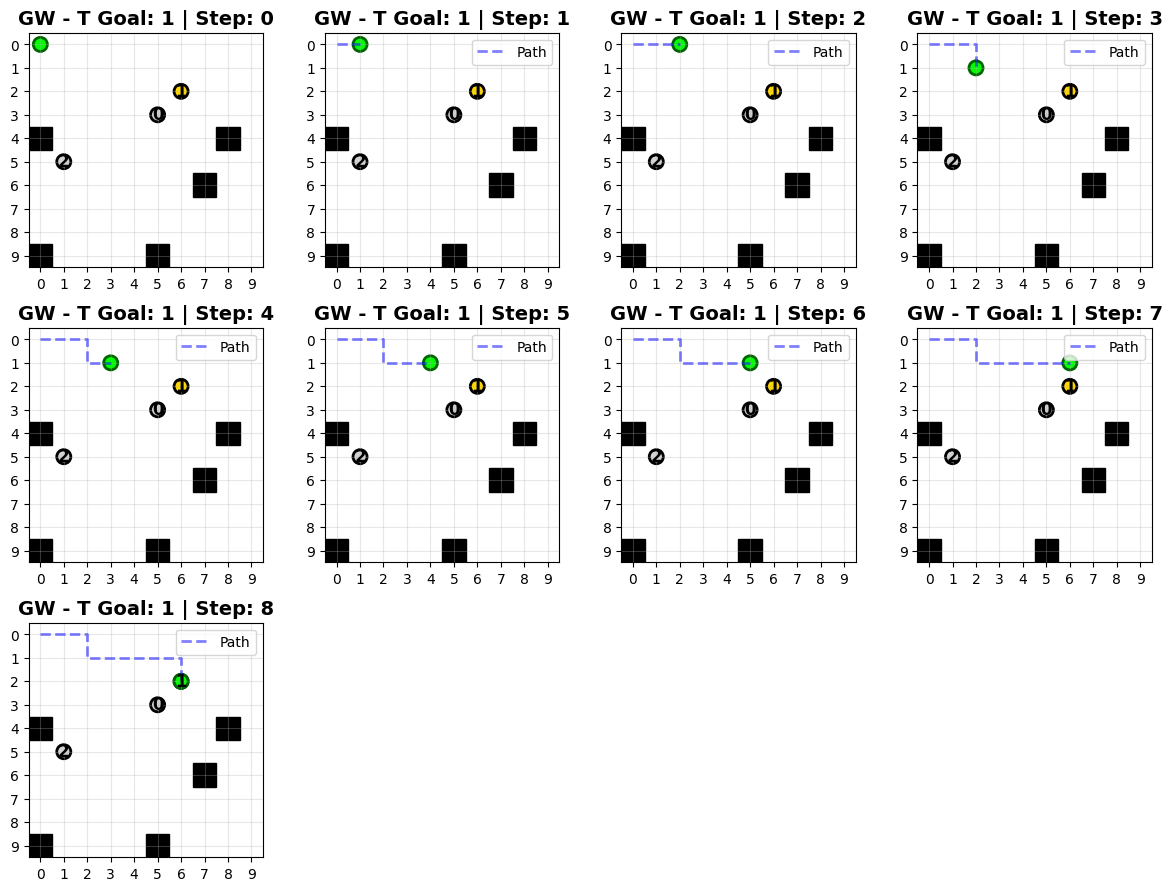

✓ Training metrics saved as 'gridworld_dql_training.png'


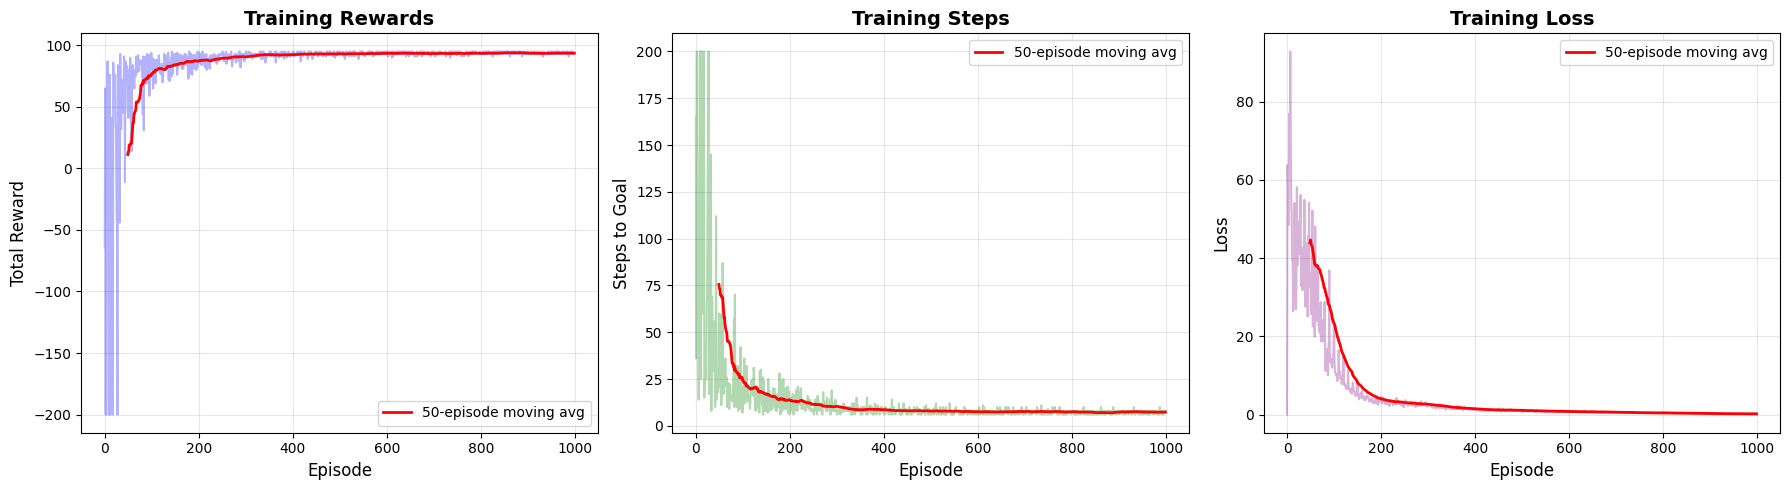


RESULTS:
Goal reached: True
Total steps taken: 8
Final position: [2 6]
Target goal position: [2 6]
Path length: 9
All positions visited: 9



In [9]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from typing import Optional, Tuple, List
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

class MultiGoalGridWorld(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size: int = 10, target_goal: int = 0,
                 num_goals: int = 3, num_obstacles: int = 10):
        super().__init__()

        self.grid_size = grid_size
        self.num_goals = num_goals
        self.target_goal = target_goal
        self.num_obstacles = num_obstacles

        # Define action and observation space
        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.action_space = spaces.Discrete(4)

        # Observation: [agent_x, agent_y, goal_x, goal_y]
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(4,), dtype=np.int32
        )

        # Initialize positions
        self.agent_pos = np.array([0, 0])
        self.goals = []
        self.obstacles = []
        self._generate_world()

    def _generate_world(self):
        self.goals = []
        self.obstacles = []

        # Get all available positions (excluding agent start)
        available_positions = [
            (x, y) for x in range(self.grid_size)
            for y in range(self.grid_size)
            if (x, y) != tuple(self.agent_pos)
        ]

        # Total positions needed
        total_needed = min(self.num_goals + self.num_obstacles, len(available_positions))

        # Randomly select positions
        selected_indices = np.random.choice(
            len(available_positions),
            size=total_needed,
            replace=False
        )

        # Assign goals
        for i in range(min(self.num_goals, total_needed)):
            idx = selected_indices[i]
            self.goals.append(np.array(available_positions[idx]))

        # Assign obstacles
        for i in range(self.num_goals, total_needed):
            idx = selected_indices[i]
            self.obstacles.append(np.array(available_positions[idx]))

    def _is_obstacle(self, pos: np.ndarray) -> bool:
        for obs in self.obstacles:
            if np.array_equal(pos, obs):
                return True
        return False

    def _get_obs(self):
        target_pos = self.goals[self.target_goal]
        return np.concatenate([self.agent_pos, target_pos]).astype(np.int32)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)

        # Reset agent to fixed start position
        self.agent_pos = np.array([0, 0])

        # Ensure target_goal is valid
        if self.target_goal >= len(self.goals):
            self.target_goal = 0

        return self._get_obs(), {}

    def step(self, action: int):
        # Map actions to movements
        direction_map = {
            0: np.array([-1, 0]),  # UP
            1: np.array([0, 1]),   # RIGHT
            2: np.array([1, 0]),   # DOWN
            3: np.array([0, -1])   # LEFT
        }

        # Calculate new position
        new_pos = self.agent_pos + direction_map[action]

        # Check boundaries
        new_pos = np.clip(new_pos, 0, self.grid_size - 1)

        # Check if new position is an obstacle
        if not self._is_obstacle(new_pos):
            self.agent_pos = new_pos

        # Check if reached target goal
        target_pos = self.goals[self.target_goal]
        reached_goal = np.array_equal(self.agent_pos, target_pos)

        # Calculate reward
        if reached_goal:
            reward = 100.0
            terminated = True
        else:
            reward = -1.0  # Step penalty
            terminated = False

        truncated = False

        return self._get_obs(), reward, terminated, truncated, {}

    def render_grid(self, ax=None, agent_path=None, current_step=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.invert_yaxis()

        # Draw obstacles
        for obs in self.obstacles:
            rect = Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                           facecolor='black', edgecolor='black')
            ax.add_patch(rect)

        # Draw goals
        for idx, goal in enumerate(self.goals):
            color = 'gold' if idx == self.target_goal else 'lightgray'
            circle = Circle((goal[1], goal[0]), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(goal[1], goal[0], str(idx), ha='center', va='center',
                   fontsize=12, fontweight='bold')

        # Draw agent path if provided
        if agent_path and len(agent_path) > 1:
            path_array = np.array([p[:2] for p in agent_path])  # Use only agent position
            ax.plot(path_array[:, 1], path_array[:, 0], 'b--', alpha=0.5, linewidth=2, label='Path')

        # Draw agent
        agent_circle = Circle((self.agent_pos[1], self.agent_pos[0]), 0.3,
                             color='lime', ec='darkgreen', linewidth=2)
        ax.add_patch(agent_circle)

        title = f'GW - T Goal: {self.target_goal}'
        if current_step is not None:
            title += f' | Step: {current_step}'
        ax.set_title(title, fontsize=14, fontweight='bold')

        if agent_path and len(agent_path) > 1:
            ax.legend(loc='upper right')

        return ax


class QNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class DQLAgent:
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.0005,
                 discount_factor: float = 0.95, epsilon: float = 1.0,
                 epsilon_decay: float = 0.995, epsilon_min: float = 0.01,
                 buffer_size: int = 10000, batch_size: int = 64):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        # Initialize networks
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)  # Explore
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()  # Exploit

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute current Q-values
        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss
        loss = nn.MSELoss()(q_values, targets)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()  # Return loss for logging

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


def train_and_visualize(grid_size=10, num_goals=3, num_obstacles=15, episodes=1000):

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=grid_size,
        target_goal=0,  # Initial target goal (will change per episode)
        num_goals=num_goals,
        num_obstacles=num_obstacles
    )

    # Create agent
    agent = DQLAgent(
        state_size=4,  # [agent_x, agent_y, goal_x, goal_y]
        action_size=env.action_space.n,
        learning_rate=0.0005,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=64
    )

    # Training metrics
    episode_rewards = []
    episode_steps = []
    episode_goals = []
    episode_losses = []

    print("Training Deep Q-Learning Agent with Changing Target Goals...")
    print(f"Grid Size: {grid_size}x{grid_size}")
    print(f"Number of Goals: {num_goals}")
    print(f"Number of Obstacles: {num_obstacles}")
    print(f"Episodes: {episodes}\n")

    # Training loop
    target_update_freq = 10  # Update target network every 10 episodes
    for episode in range(episodes):
        # Set a new random target goal for this episode
        env.target_goal = np.random.randint(0, num_goals)
        episode_goals.append(env.target_goal)

        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:  # Max steps per episode
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            agent.memory.push(state, action, reward, next_state, done)

            # Update Q-network
            loss = agent.update()
            if loss is not None:
                episode_loss += loss
                loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / max(loss_count, 1))

        # Update target network
        if (episode + 1) % target_update_freq == 0:
            agent.update_target_network()

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            avg_loss = np.mean(episode_losses[-100:])
            most_common_goal = np.bincount(episode_goals[-100:]).argmax()
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Avg Loss: {avg_loss:.4f}, "
                  f"Most Common Goal: {most_common_goal}, "
                  f"Epsilon: {agent.epsilon:.3f}")

    print("\n✓ Training Complete!\n")

    # Test the trained agent with visualization
    print("Testing Trained Agent (ALL Steps Visualization)...")
    env.target_goal = np.random.randint(0, num_goals)  # Random goal for testing
    print(f"Testing with Target Goal: {env.target_goal}")
    state, _ = env.reset()
    done = False
    steps = 0
    agent_path = [state.copy()]
    all_positions = [state.copy()]

    while not done and steps < 200:
        action = agent.get_action(state)
        agent.epsilon = 0  # Use greedy policy for testing

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent_path.append(next_state.copy())
        all_positions.append(next_state.copy())
        state = next_state
        steps += 1

    print(f"Agent took {steps} steps to reach the goal!")
    print(f"Creating visualization for ALL {steps} steps...\n")

    # Calculate grid layout for all steps
    total_steps = len(all_positions)

    # Determine grid layout based on number of steps
    if total_steps <= 6:
        rows, cols = 2, 3
    elif total_steps <= 12:
        rows, cols = 3, 4
    elif total_steps <= 20:
        rows, cols = 4, 5
    elif total_steps <= 30:
        rows, cols = 5, 6
    else:
        rows, cols = 6, 8

    # Create multiple figures if needed
    steps_per_figure = rows * cols
    num_figures = (total_steps + steps_per_figure - 1) // steps_per_figure

    for fig_num in range(num_figures):
        start_idx = fig_num * steps_per_figure
        end_idx = min(start_idx + steps_per_figure, total_steps)
        steps_in_fig = end_idx - start_idx

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()

        print(f"Generating figure {fig_num + 1}/{num_figures} (Steps {start_idx} to {end_idx - 1})...")

        for i in range(steps_per_figure):
            ax = axes[i]
            step_idx = start_idx + i

            if step_idx < total_steps:
                env.agent_pos = all_positions[step_idx][:2]  # Use only agent position
                current_path = all_positions[:step_idx + 1]
                env.render_grid(ax, agent_path=current_path, current_step=step_idx)
            else:
                ax.axis('off')

        plt.tight_layout()
        filename = f'gridworld_all_steps_part{fig_num + 1}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {filename}")
        plt.show()

    # Plot training metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot rewards
    ax1.plot(episode_rewards, alpha=0.3, color='blue')
    window = 50
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('Training Rewards', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot steps
    ax2.plot(episode_steps, alpha=0.3, color='green')
    if len(episode_steps) >= window:
        moving_avg = np.convolve(episode_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_steps)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Steps to Goal', fontsize=12)
    ax2.set_title('Training Steps', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot losses
    ax3.plot(episode_losses, alpha=0.3, color='purple')
    if len(episode_losses) >= window:
        moving_avg = np.convolve(episode_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(episode_losses)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax3.set_xlabel('Episode', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('gridworld_dql_training.png', dpi=150, bbox_inches='tight')
    print(f"✓ Training metrics saved as 'gridworld_dql_training.png'")
    plt.show()

    print(f"\n{'='*60}")
    print(f"RESULTS:")
    print(f"{'='*60}")
    print(f"Goal reached: {done}")
    print(f"Total steps taken: {steps}")
    print(f"Final position: {state[:2]}")
    print(f"Target goal position: {env.goals[env.target_goal]}")
    print(f"Path length: {len(agent_path)}")
    print(f"All positions visited: {len(all_positions)}")
    print(f"{'='*60}\n")

    return env, agent, episode_rewards, episode_steps, episode_goals, episode_losses


# Run the training and visualization
if __name__ == "__main__":
    env, agent, rewards, steps, goals, losses = train_and_visualize(
        grid_size=10,
        num_goals=3,
        num_obstacles=5,
        episodes=1000
    )

 ## Performance Differences
The performance differences between Code A and Code B are driven by changes that enable Code B’s agent to consistently reach the target goal in a 10x10 grid with 4 goals and 3 obstacles. Below are the key differences and their impact on performance:

- State Representation:

  - Code B: Uses a state of [agent_x, agent_y, goal_x, goal_y] (shape=(4,)). The Q-network receives the target goal’s position, allowing it to learn a policy specific to each goal, which is critical when the target goal changes per episode.

  - Code A: Uses a state of [agent_x, agent_y] (shape=(2,)). The Q-network lacks information about the target goal, forcing it to learn an averaged policy across all goals, resulting in random or suboptimal navigation.

- Performance Impact:

  - Code B: The agent learns to navigate to the specific target goal, leading to higher rewards (e.g., -50 to +50 over the last 100 episodes) and fewer steps (e.g., 20–50 steps to reach the goal). The augmented state ensures the agent can adapt to the changing goal.

  - Code A: The agent struggles to reach the target goal because it cannot distinguish between the 4 goals. Rewards remain low (e.g., -100 to -200), and steps often hit the 200-step limit, as you observed (“it doesn’t go to the target goal”).


- Number of Episodes:

  - Code B: Trains for 1000 episodes, providing more time to explore and learn in the larger 10x10 grid with 4 goals.
  
  - Code A: Trains for 500 episodes, which is often insufficient for DQL convergence in a 10x10 grid, especially without goal information.


  - Performance Impact:

    - Code B: More episodes allow the agent to explore the state-action space thoroughly, improving the Q-network’s ability to learn an effective policy. Rewards increase, and steps decrease as training progresses.
  
    - Code A: Fewer episodes limit exploration, reducing the likelihood of learning a reliable policy, contributing to the agent’s failure to reach the goal consistently.




- Learning Rate:

  - Code B: Uses a learning rate of 0.0005, promoting stable gradient updates.

  - Code A: Uses a learning rate of 0.001, which can cause overshooting and instability in Q-value updates.
  - Performance Impact:

    - Code B: Stable updates help the Q-network converge to accurate Q-values, supporting consistent goal-reaching. The loss (plotted in Code B) should decrease steadily (e.g., from 10–100 to below 1).
    - Code A: The higher learning rate may lead to erratic updates, slowing convergence and exacerbating the agent’s inability to learn a goal-directed policy.




- Target Network Update Frequency:

  - Code B: Updates the target network every 10 episodes, ensuring stable Q-value targets.
  - Code A: Updates the target network every 10 training steps (in _train_step), which is too frequent and can destabilize training.
  - Performance Impact:

    - Code B: Less frequent updates stabilize training by keeping target Q-values fixed for longer, improving convergence and goal-reaching performance.
    - Code A: Frequent updates cause the target network to shift too quickly, leading to instability and poor policy learning, contributing to the agent’s failure to reach the target goal.




- Loss Tracking and Diagnostics:

  - Code B: Tracks and plots training loss, providing insight into Q-network convergence.
  - Code A: Does not track loss, making it harder to diagnose training issues.
  - Performance Impact:

    - Code B: A decreasing loss curve (in gridworld_dql_training.png) confirms that the Q-network is learning, correlating with improved rewards and fewer steps.
    - Code A: Without loss tracking, it’s unclear whether the Q-network is converging, but the lack of goal information likely results in high or erratic loss, leading to poor performance.







- Expected Performance Metrics
Here’s what to expect when running both codes on a 10x10 grid with 4 goals and 3 obstacles:

  - Code B:

    - Rewards: Average rewards over the last 100 episodes should approach 0 or become positive (e.g., -50 to +50), indicating frequent goal-reaching due to the goal-aware state.
    - Steps: Average steps should decrease below 100 (e.g., 20–50), showing efficient navigation to the target goal.
    - Loss: Training loss should decrease steadily (e.g., from 10–100 to below 1), confirming Q-network convergence.
    - Test Phase: The agent should consistently reach the target goal (gold-colored circle) within 200 steps, as seen in gridworld_all_steps_partX.png. The path should show directed movement toward the target goal.
    - Visualization: The test phase visualizations should show the agent moving toward the gold-colored goal, with the final position matching the target goal’s position.


  - Code A:

    - Rewards: Average rewards likely remain low (e.g., -100 to -200), as the agent rarely reaches the target goal due to the lack of goal information.
    - Steps: Average steps often hit the 200-step limit, indicating failure to terminate episodes by reaching the goal.
    - Loss: Not tracked, but likely high or erratic due to the Q-network’s inability to learn a goal-specific policy.
    - Test Phase: The agent may wander randomly or move toward non-target goals, as you observed (“it doesn’t go to the target goal”). The final position in the test phase is unlikely to match the target goal.
    - Visualization: The test phase path in gridworld_dqn_steps_partX.png may show random movements or navigation to incorrect goals.



- Why Code B Outperforms Code A

  - Goal-Aware State: Code B’s state [agent_x, agent_y, goal_x, goal_y] allows the Q-network to learn a policy specific to the target goal, enabling consistent navigation to the correct goal despite changes per episode. Code A’s state [agent_x, agent_y] lacks this information, resulting in an averaged policy that fails to prioritize the target goal.
  - More Episodes: Code B’s 1000 episodes (vs. Code A’s 500) provide more learning opportunities, crucial for the 10x10 grid’s larger state space.
  - Stable Training: Code B’s lower learning rate (0.0005 vs. 0.001) and less frequent target network updates (every 10 episodes vs. every 10 steps) stabilize training, improving convergence.
  - Diagnostics: Code B’s loss tracking confirms learning progress, while Code A’s lack of loss tracking obscures training issues.



- Conclusion

Code B outperforms Code A because its augmented state representation includes the target goal’s position, enabling the agent to learn a goal-specific policy. Additional factors like more episodes (1000 vs. 500), a lower learning rate (0.0005 vs. 0.001), less frequent target network updates, and loss tracking further enhance Code B’s performance. In a 10x10 grid with 4 goals, Code B should show significantly better rewards, fewer steps, and consistent goal-reaching compared to Code A.
If you run Code B and still encounter issues, share the training output (rewards, steps, loss) or test phase behavior (e.g., path in visualizations), and I can suggest further optimizations, such as reward shaping or state normalization.